In [1]:
import datetime as dt
import numpy as np
import xarray as xr

import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import xarray_regrid
import subprocess
from joblib import Parallel, delayed
import dask.array as da

In [21]:
#make a download directory
import os
if not os.path.exists('download'):
    os.makedirs('download')
if not os.path.exists('figures/forecast2324'):
    os.makedirs('figures/forecast2324')

In [3]:
download = False

## Load Data

In [ ]:
cfsv2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cfsv2_path = 'download/cfsv2_precip_fcast.nc'

gfdlspear_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
gfdlspear_path = 'download/gfdlspear_precip_fcast.nc'

cansipsic4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPS-IC4/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cansipsic4_path = 'download/cansipsic4_precip_fcast.nc'

cesm1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CESM1/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cesm1_path = 'download/cesm1_precip_fcast.nc'

colaccsm4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
colaccsm4_path = 'download/colaccsm4_precip_fcast.nc'

nasageos_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos_path = 'download/nasageos_precip_fcast.nc'

if download:
    print(cfsv2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cfsv2_url, '-o', cfsv2_path])
    print(gfdlspear_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', gfdlspear_url, '-o', gfdlspear_path])
    print(cesm1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cesm1_url, '-o', cesm1_path])
    print(colaccsm4_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', colaccsm4_url, '-o', colaccsm4_path])
    print(nasageos_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos_url, '-o', nasageos_path])

    #print(cansipsic4_url)
    #subprocess.call(['curl', '-b', 'cookies.txt', '-k', cansipsic4_url, '-o', cansipsic4_path])
    

In [5]:
cfsv2 = xr.open_dataset(cfsv2_path, decode_times=True)
gfdlspear = xr.open_dataset(gfdlspear_path, decode_times=True)
cesm1 = xr.open_dataset(cesm1_path, decode_times=True)
colaccsm4 = xr.open_dataset(colaccsm4_path, decode_times=True)
nasageos = xr.open_dataset(nasageos_path, decode_times=True)
#cansipsic4 = xr.open_dataset(cansipsic4_path, decode_times=True)

In [6]:
cmap_url = "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cmap_path = 'download/cmap_precip.nc'

print(cmap_url)
subprocess.call(['curl', '-b', 'cookies.txt', '-k', cmap_url, '-o', cmap_path])

cmap = xr.open_dataset(cmap_path, decode_times=True)
#change datetime to 01-MM-YYYY
new_dates = pd.to_datetime(cmap['T'].values, format="%d-%m-%Y").strftime("01-%m-%Y")
cmap['T'] = pd.to_datetime(new_dates, format="%d-%m-%Y")
obs = cmap['prcp_est']

obs_3m = obs + obs.shift(T=1) + obs.shift(T=2)
obs_3m = obs_3m.dropna('T')
#convert T to pd.datetime
obs_3m['T'] = pd.to_datetime(obs_3m['T'].values, format="%d-%m-%Y")


https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


In [7]:
spi_obs = xr.load_dataset('data/spi3_cmap_1x1.nc')
#rename variable __xarray_dataarray_variable__ to spi
spi_obs = spi_obs.rename({'__xarray_dataarray_variable__':'spi'}).spi.sortby('T')
spi_obs['T'] = pd.to_datetime(spi_obs['T'].values, format="%Y-%m-%d")


## Forecast

In [8]:
nmme_dict =  {'cfsv2': cfsv2, 'gfdlspear': gfdlspear, 'cesm1': cesm1, 'colaccsm4': colaccsm4, 'nasageos': nasageos}

precip_fcast_dict = {'cfsv2': None, 'gfdlspear': None, 'cesm1': None, 'colaccsm4': None, 'nasageos': None}
spi_fcast_dict = {'cfsv2': None, 'gfdlspear': None, 'cesm1': None, 'colaccsm4': None, 'nasageos': None}


In [9]:
n_lead = 6
for (nmme_name, nmme) in nmme_dict.items():
    print(f"######################")
    print(f"Processing NMME: {nmme_name.upper()}")
    print(f"######################")
    P_bar_all = nmme.mean(dim='M')['prec']
    P_bar = P_bar_all.sel(S=slice('2023-01-01','2024-12-31'))
    fcast_starts = P_bar['S'].values
    # Initialize storage
    x_range = P_bar['X'].values
    y_range = P_bar['Y'].values

    P_storage = np.full((len(fcast_starts), n_lead, len(y_range), len(x_range)), np.nan)
    spi_storage = np.full((len(fcast_starts), n_lead, len(y_range), len(x_range)), np.nan)

    # Define a function to compute SPI for a single grid point
    def compute_spi_single_grid(i, j, blend_series_season, s,l):
        data_grid = blend_series_season.sel(X=x_range[j], Y=y_range[i])
        t = s + pd.DateOffset(months=int(l))
        t_month = t.month
        data_grid_month = data_grid.sel(T=data_grid['T.month'] == t_month).values

        if np.all(np.isnan(data_grid_month)):  # Skip if all values are NaN
            return np.nan

        # Fit Pearson Type III distribution
        try:
            a, loc, scale = sp.stats.pearson3.fit(data_grid_month)
            cdf_values = sp.stats.pearson3.cdf(data_grid_month, skew=a, loc=loc, scale=scale)

            # Handle zero-inflated data
            q = np.sum(data_grid_month == 0) / len(data_grid_month)
            cdf_values = (cdf_values * (1 - q)) + q

            # Ensure CDF is within valid bounds
            cdf_values = np.clip(cdf_values, 1e-6, 1 - 1e-6)

            # Convert CDF to SPI
            spi_time_series = sp.stats.norm.ppf(cdf_values)
            return spi_time_series[-1]
        except Exception as e:
            print(f"Error fitting distribution at (X={x_range[j]}, Y={y_range[i]}): {e}")
            return np.nan

    # Process each forecast start
    for s in range(len(fcast_starts)):
        print(f"Computing SPI for forecast starting {fcast_starts[s]}")
        fcast_start = fcast_starts[s].astype('datetime64[s]').item()
        month = fcast_start.month

        # Compute climatology and anomalies
        P_bar_month = P_bar.sel(S=P_bar['S.month'] == month)
        P_c = P_bar_month.where(P_bar_month['S'] != fcast_starts[s]).mean(dim='S')
        P_a = P_bar - P_c

        ty_1 = fcast_start - relativedelta(years=1)
        ty_30 = fcast_start - relativedelta(years=30)

        obs_month = obs.sel(T=obs['T.month'] == month)
        obs_climo = obs_month.sel(T=slice(ty_30, ty_1)).mean(dim='T')
        P_fcst = P_a + obs_climo
        P_fcst_s = P_fcst.sel(S=fcast_start)
        # Create a new xarray with T as a dimension
        L_values = np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5,6.5,7.5])[0:n_lead]
        T_values = [fcast_start + pd.DateOffset(months=int(L - 0.5)) for L in L_values]
        P_fcst = xr.concat(
            [P_fcst_s.sel(L=L).expand_dims(T=[T]) for L, T in zip(L_values, T_values)],
            dim="T"
        ).drop_vars('L')

        P_obs = obs.sel(T=slice(ty_30, fcast_start - relativedelta(months=1)))
        blend_series = xr.concat([P_obs, P_fcst], dim='T').sortby('T')
        blend_series_season = blend_series + blend_series.shift(T=1) + blend_series.shift(T=2)
        blend_series_season = blend_series_season.dropna('T').sortby('T')
        for l in range(n_lead):
            P_storage[s, l, :, :] = blend_series_season.isel(T=-n_lead+l).values

        # Parallelize SPI computation across grid points
        def compute_spi_for_time(s,l):
            return Parallel(n_jobs=-1)(
                delayed(compute_spi_single_grid)(i, j, blend_series_season, s,l)
                for i in range(len(y_range))
                for j in range(len(x_range))
            )

        # Store SPI results
        for l in range(n_lead):
            print(f"-Computing SPI for lead time {l + 1}")
            results = compute_spi_for_time(s=fcast_start, l=l)
            spi_storage[s, l, :, :] = np.array(results).reshape(len(y_range), len(x_range))


    # Convert SPI storage to an xarray
    spi_s = xr.DataArray(
        spi_storage,
        dims=['S', 'L', 'Y', 'X'],
        coords={'S': fcast_starts, 'L': L_values, 'Y': y_range, 'X': x_range},
        name='spi'
    )

    P_s = xr.DataArray(
        P_storage,
        dims=['S', 'L', 'Y', 'X'],
        coords={'S': fcast_starts, 'L': L_values, 'Y': y_range, 'X': x_range},
        name='precip')
    

    # Concatenate all forecasts
    P_fcst = xr.concat(P_s, dim='S')
    spi_fcst = xr.concat(spi_s, dim='S')

    # Store the results
    precip_fcast_dict[nmme_name] = P_fcst
    spi_fcast_dict[nmme_name] = spi_fcst
    # Save the results
    P_fcst.to_netcdf(f'data/precip_fcast_{nmme_name}_2324.nc')
    spi_fcst.to_netcdf(f'data/spi_fcast_{nmme_name}_2324.nc')



######################
Processing NMME: CFSV2
######################
Computing SPI for forecast starting 2023-01-01T00:00:00.000000000
-Computing SPI for lead time 1
-Computing SPI for lead time 2
-Computing SPI for lead time 3
-Computing SPI for lead time 4
-Computing SPI for lead time 5
-Computing SPI for lead time 6
Computing SPI for forecast starting 2023-02-01T00:00:00.000000000
-Computing SPI for lead time 1
-Computing SPI for lead time 2
-Computing SPI for lead time 3
-Computing SPI for lead time 4
-Computing SPI for lead time 5
-Computing SPI for lead time 6
Computing SPI for forecast starting 2023-03-01T00:00:00.000000000
-Computing SPI for lead time 1
-Computing SPI for lead time 2
-Computing SPI for lead time 3
-Computing SPI for lead time 4
-Computing SPI for lead time 5
-Computing SPI for lead time 6
Computing SPI for forecast starting 2023-04-01T00:00:00.000000000
-Computing SPI for lead time 1
-Computing SPI for lead time 2
-Computing SPI for lead time 3
-Computing SPI f

In [10]:
spi_fcast_multimodel = xr.concat([spi_fcast_dict[nmme_name] for nmme_name in nmme_dict.keys()], dim='nmme').mean(dim='nmme')
spi_fcast_multimodel.to_netcdf(f'data/spi_fcast_multimodel_2324.nc')

precip_fcast_multimodel = xr.concat([precip_fcast_dict[nmme_name] for nmme_name in nmme_dict.keys()], dim='nmme').mean(dim='nmme')
precip_fcast_multimodel.to_netcdf(f'data/precip_fcast_multimodel_2324.nc')

## Skill

In [9]:
spi_fcast_multimodel = xr.load_dataset('data/spi_fcast_multimodel_2324.nc')
precip_fcast_multimodel = xr.load_dataset('data/precip_fcast_multimodel_2324.nc')

In [10]:
spi_fcast_multimodel = spi_fcast_multimodel.spi
precip_fcast_multimodel = precip_fcast_multimodel.precip

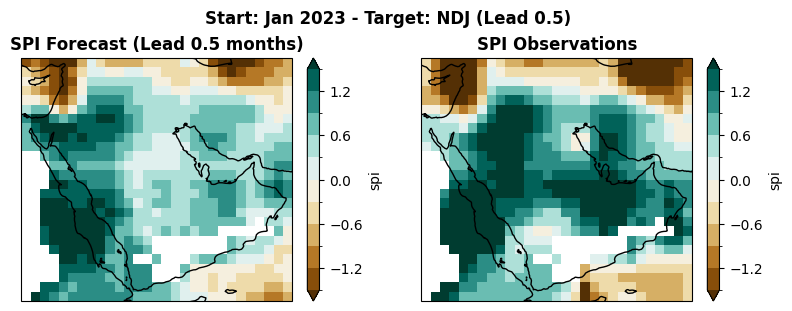

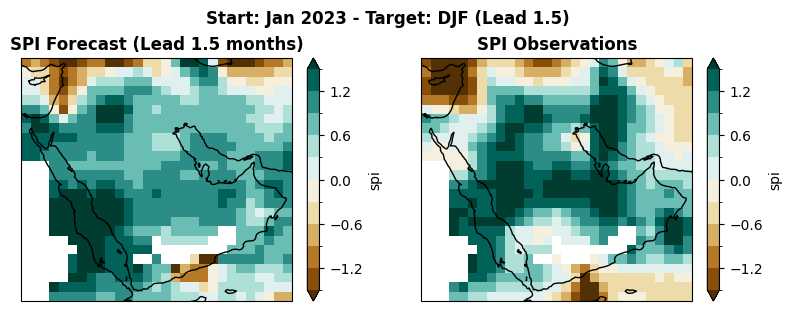

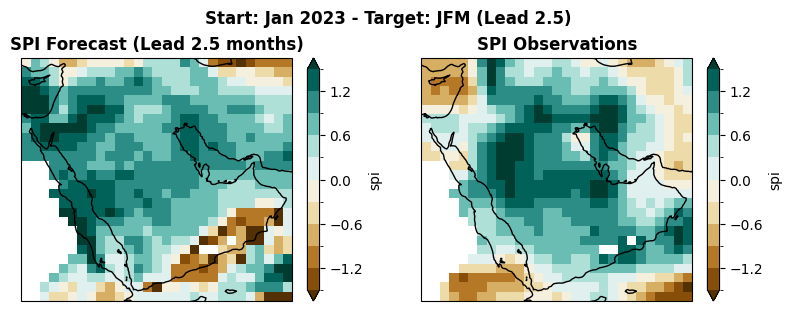

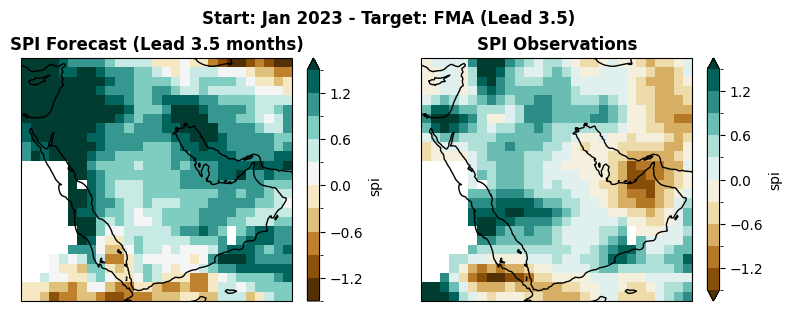

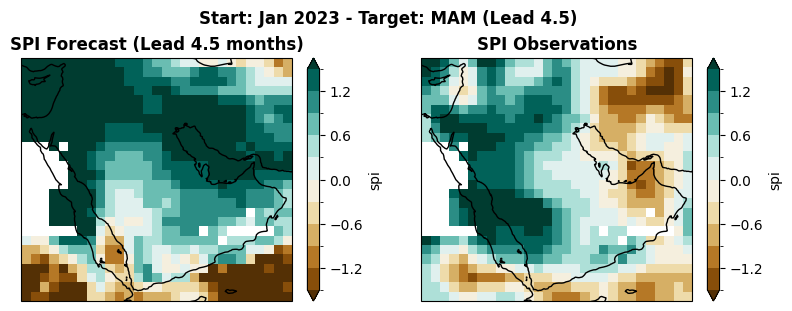

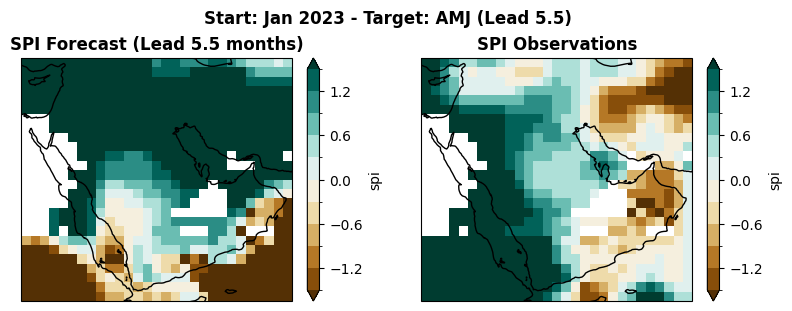

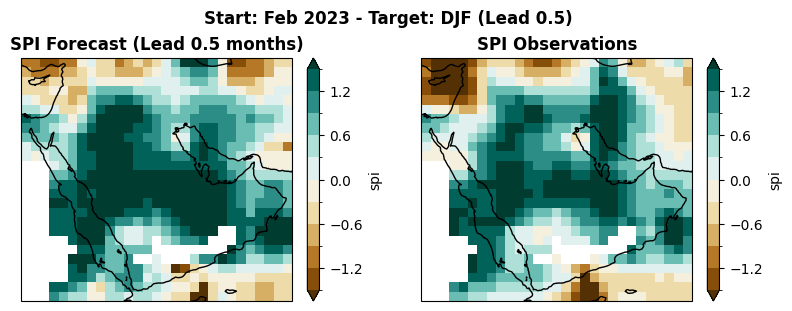

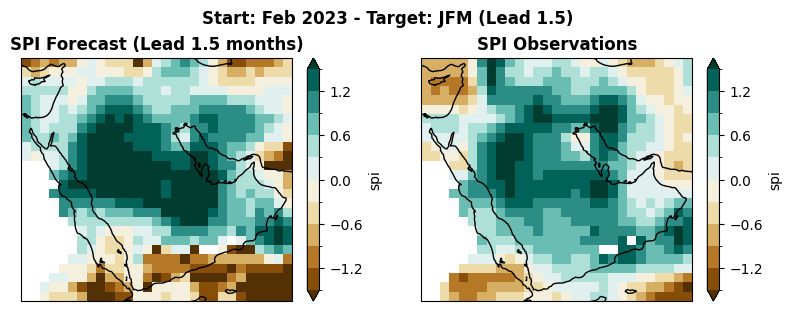

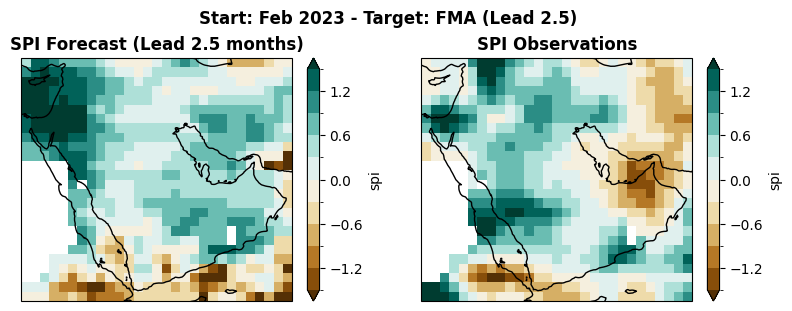

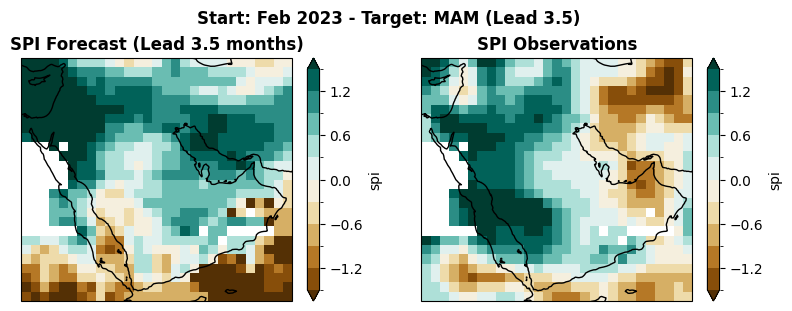

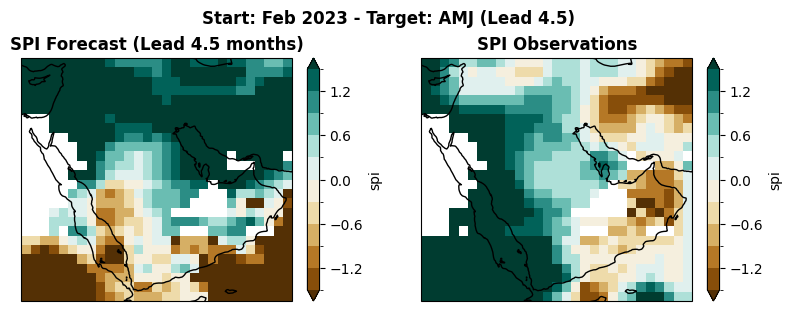

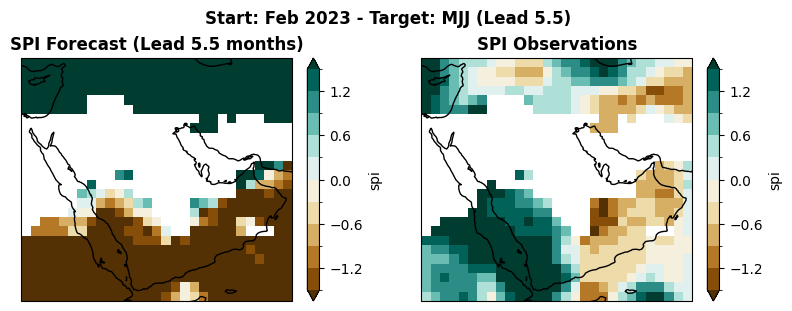

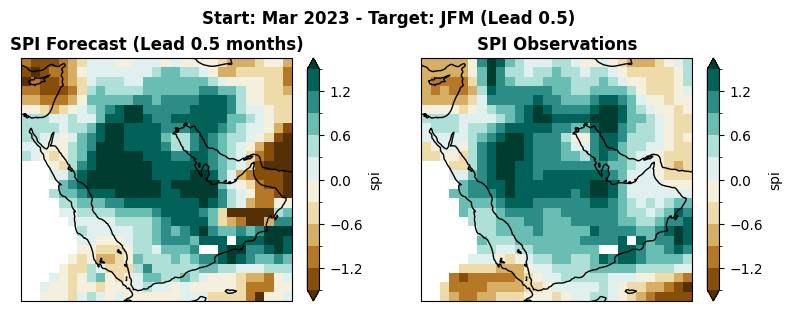

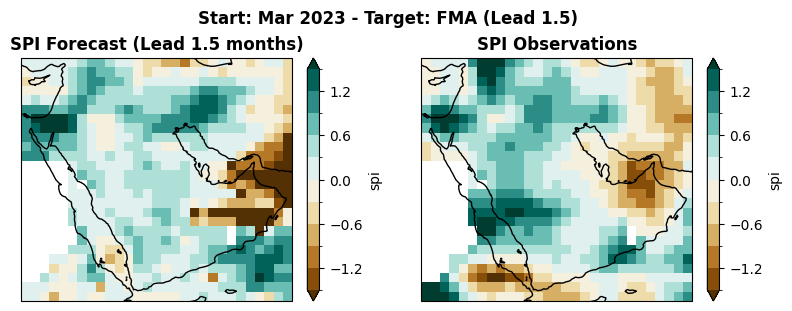

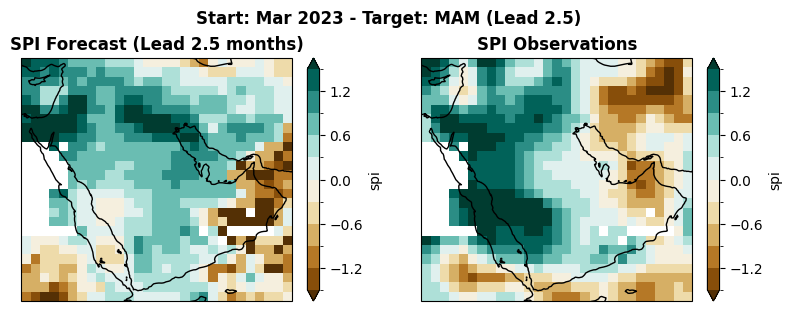

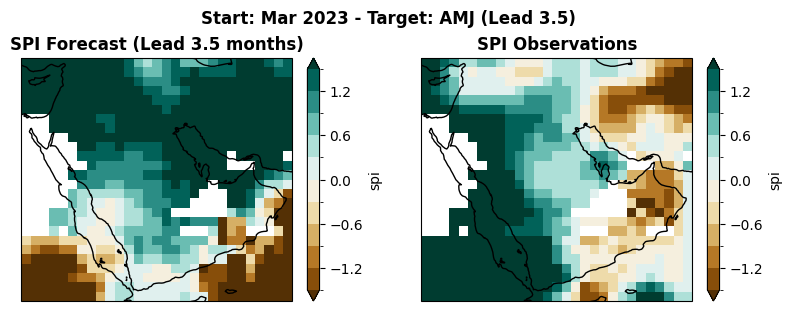

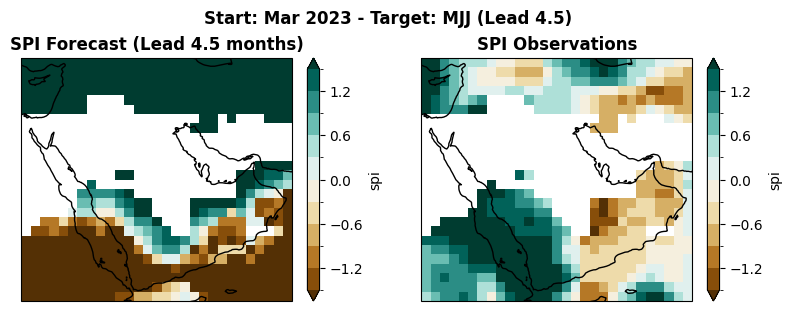

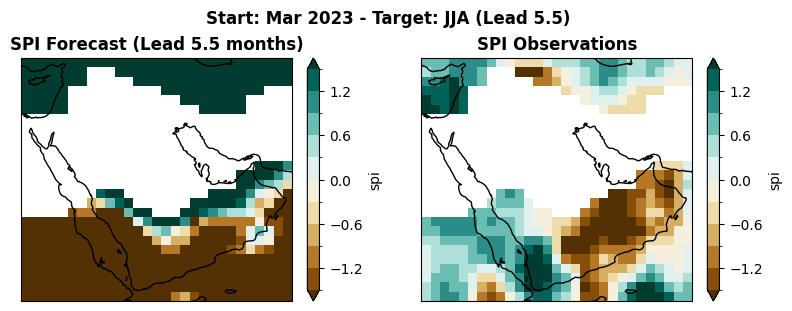

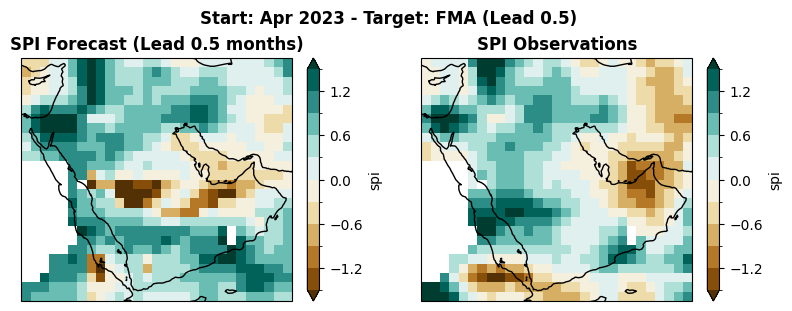

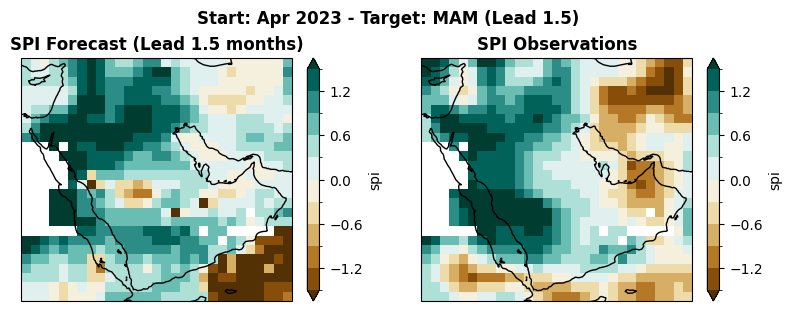

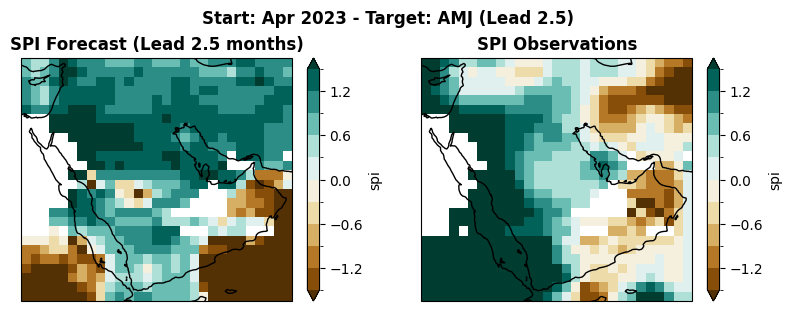

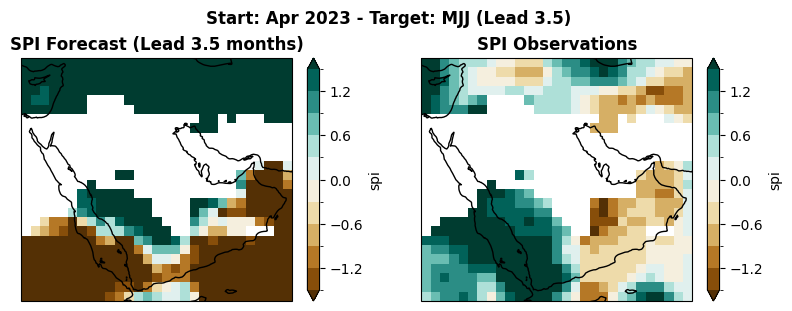

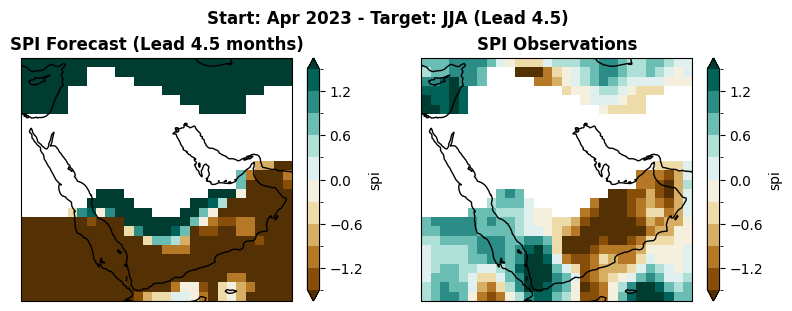

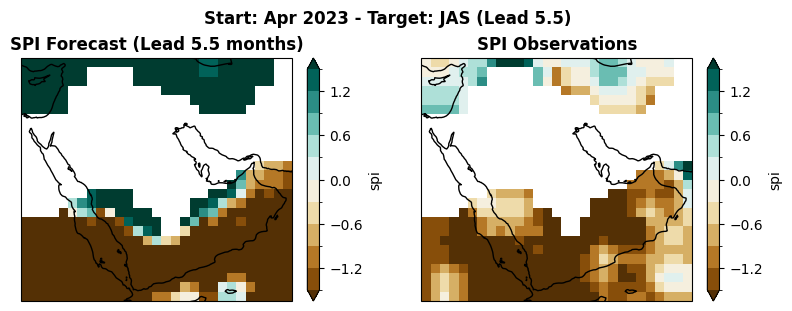

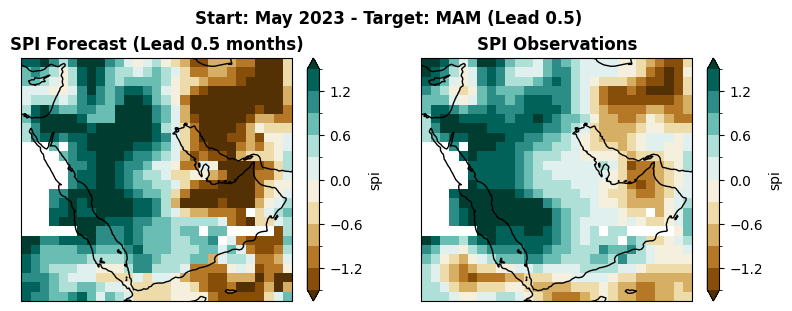

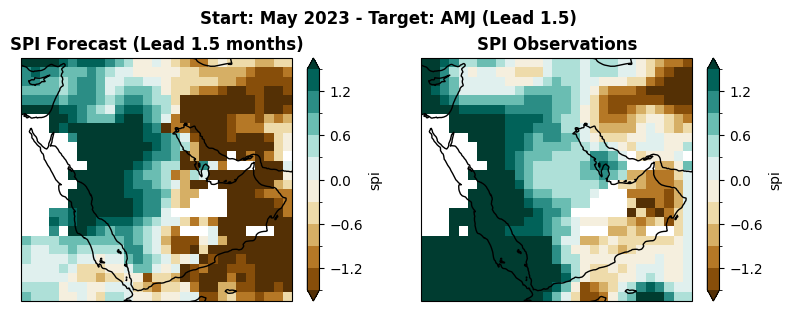

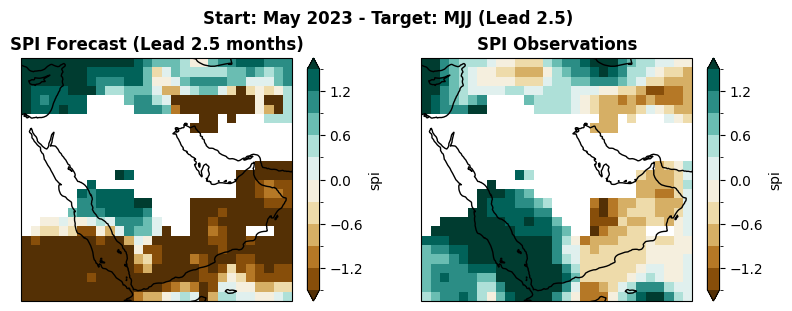

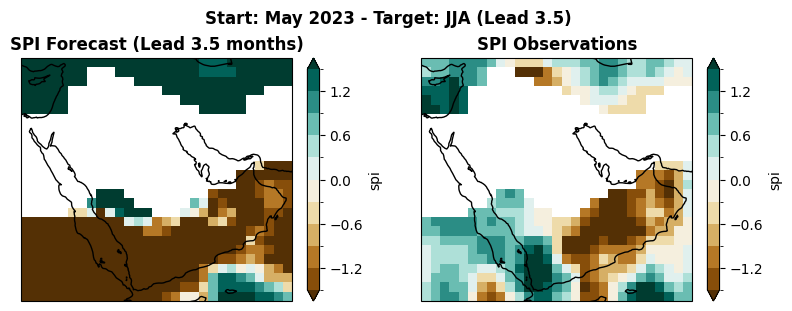

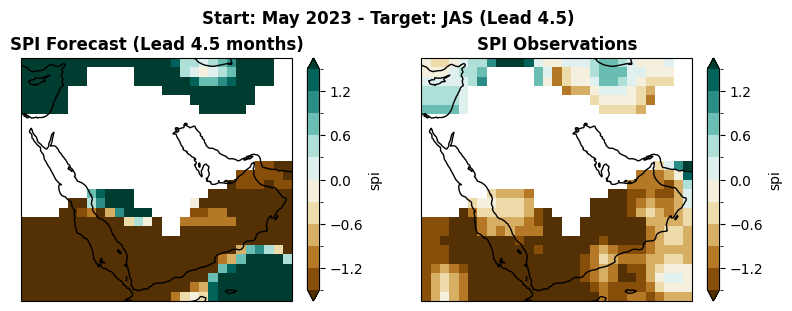

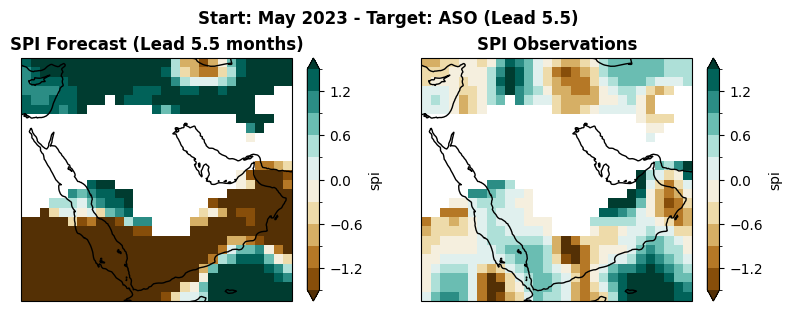

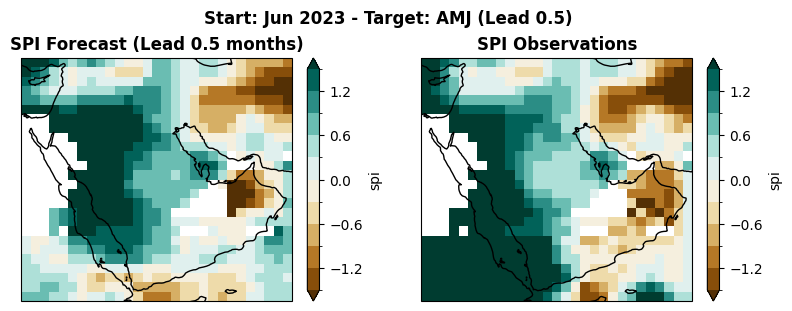

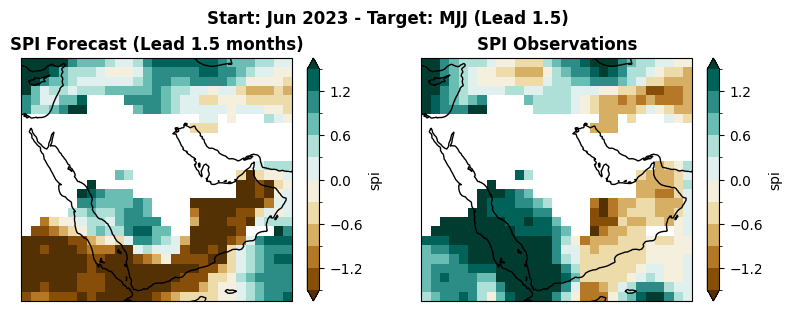

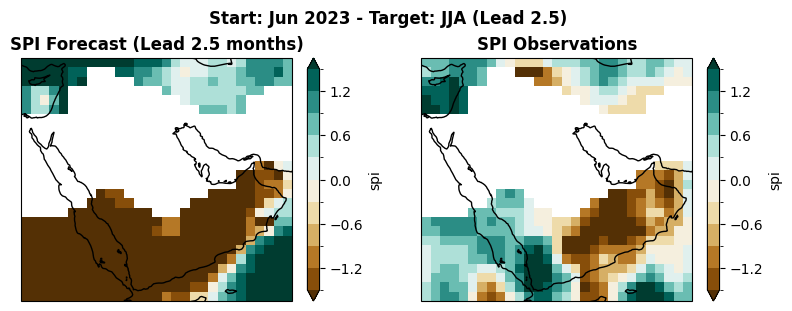

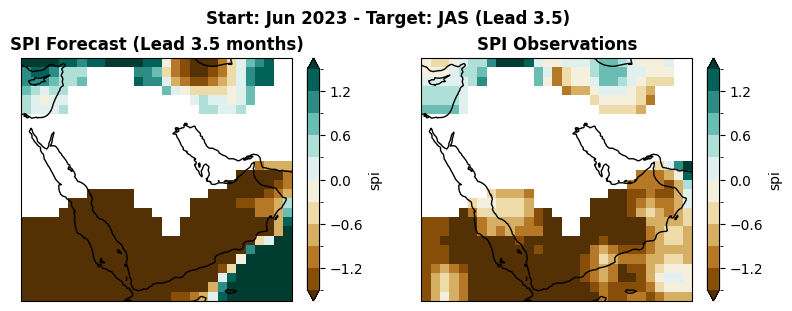

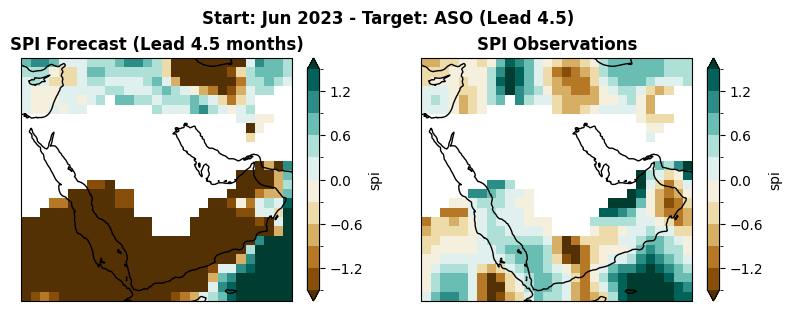

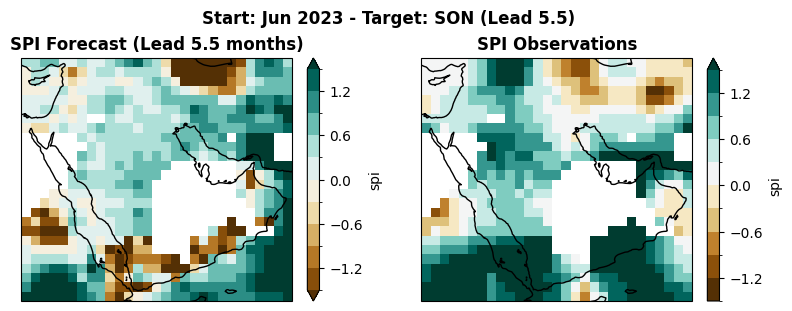

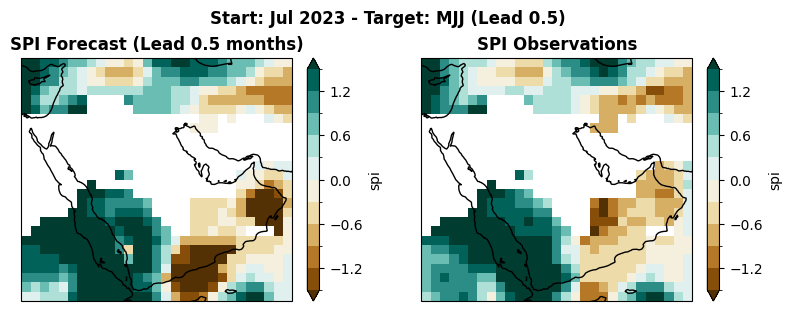

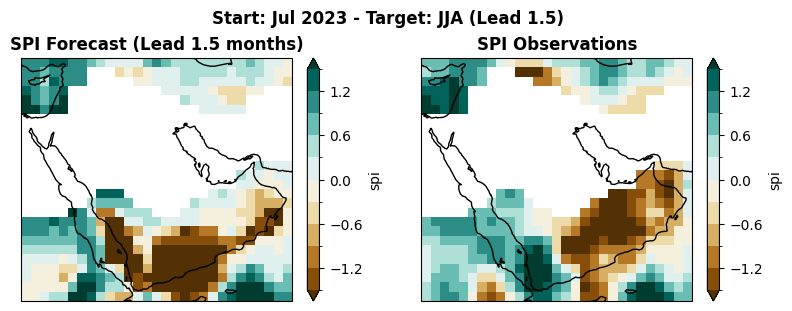

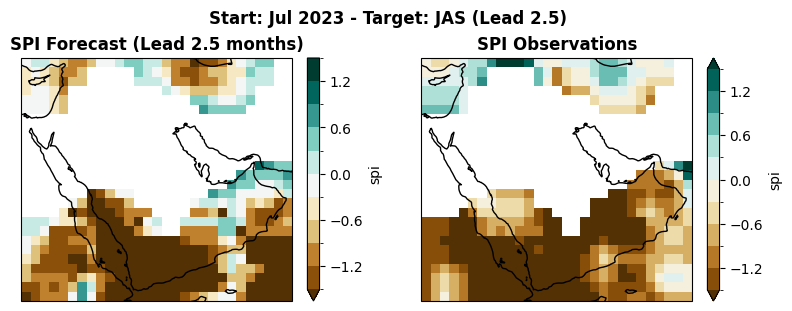

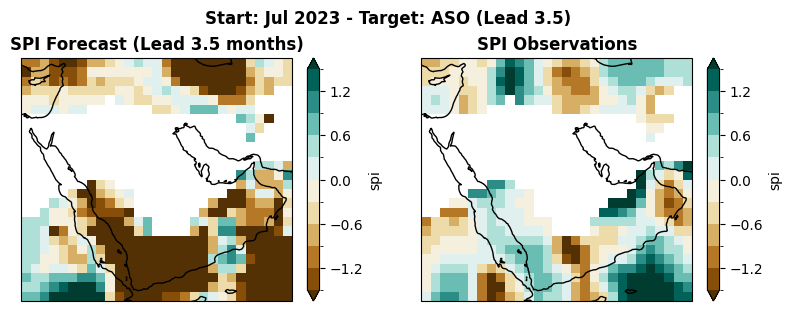

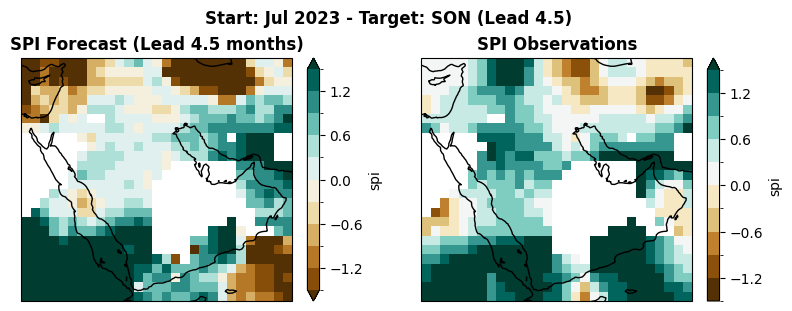

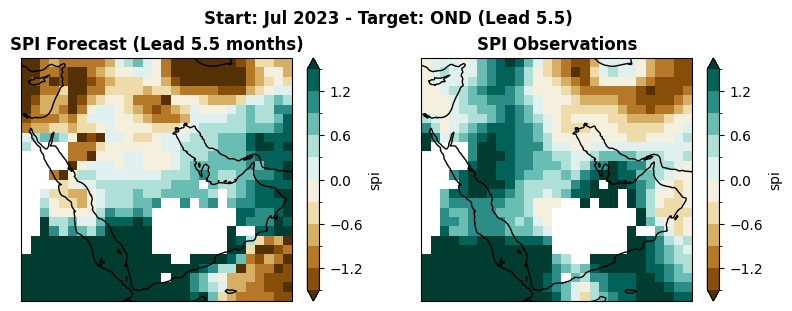

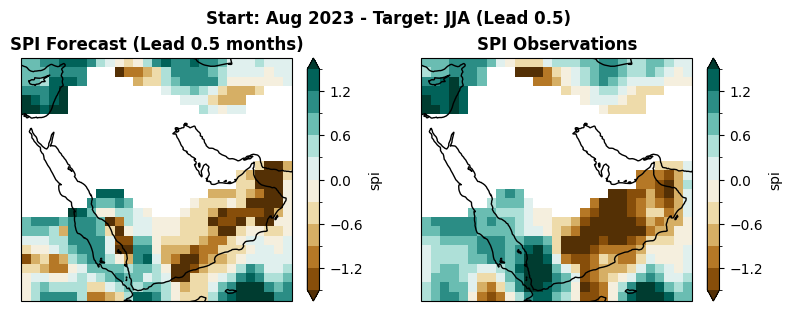

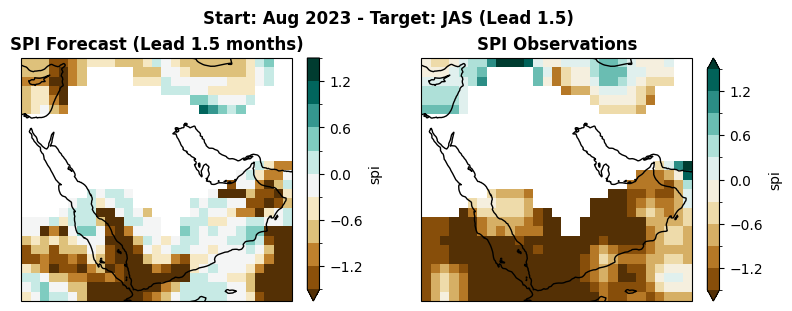

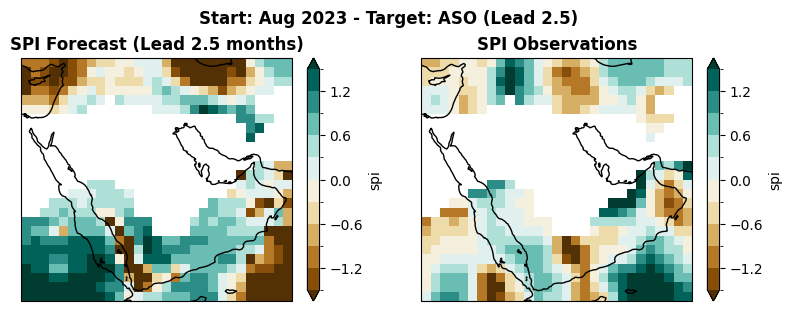

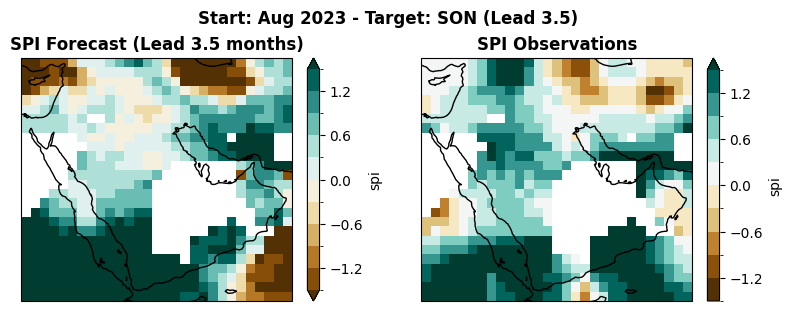

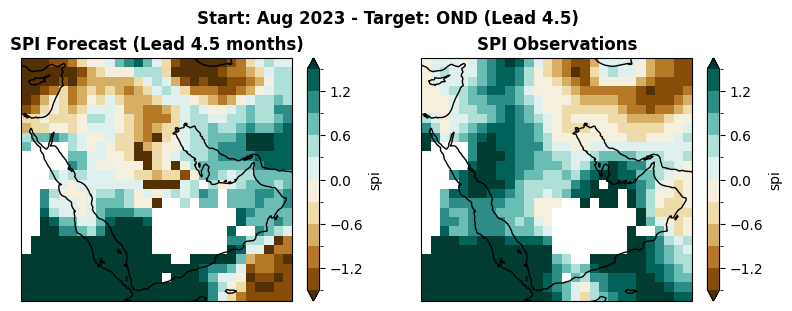

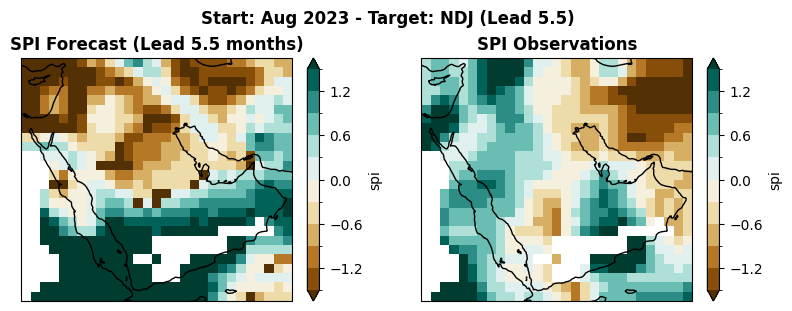

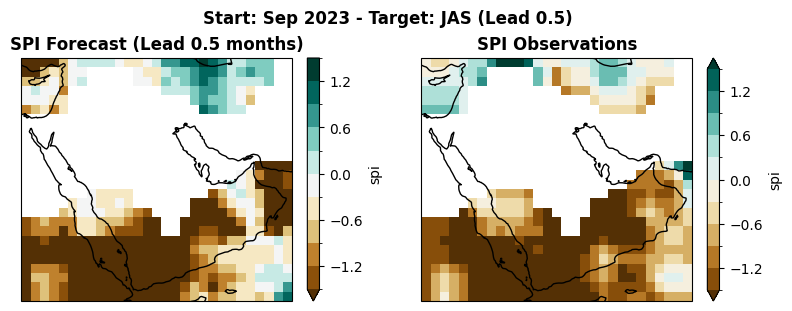

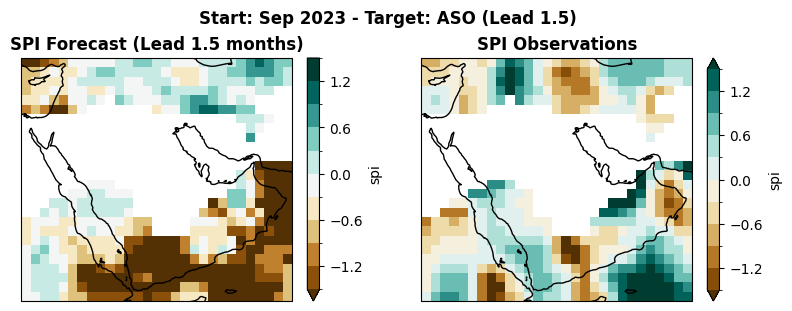

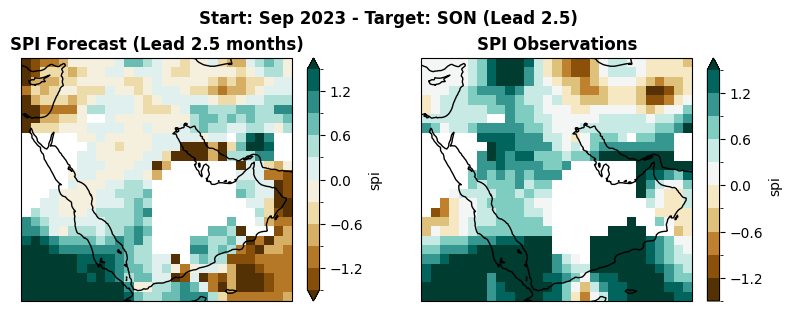

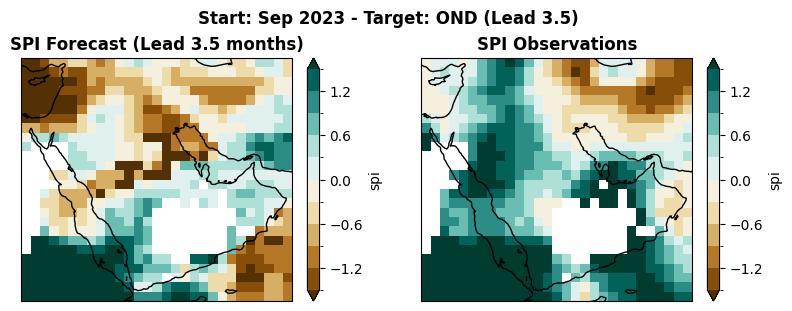

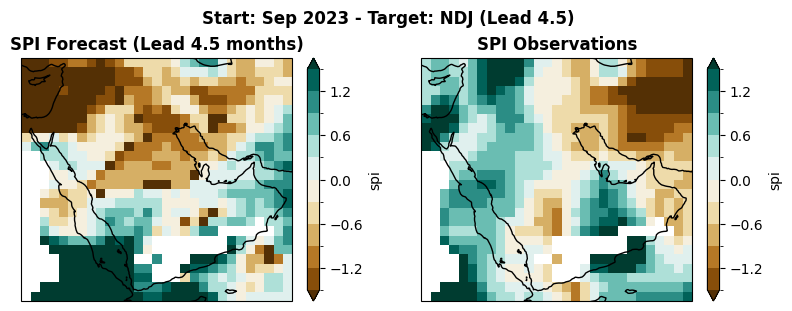

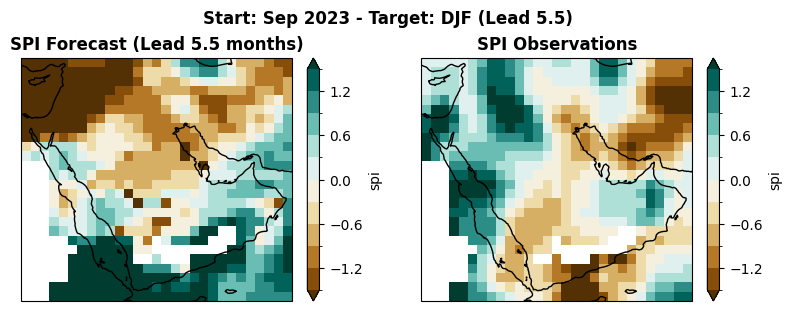

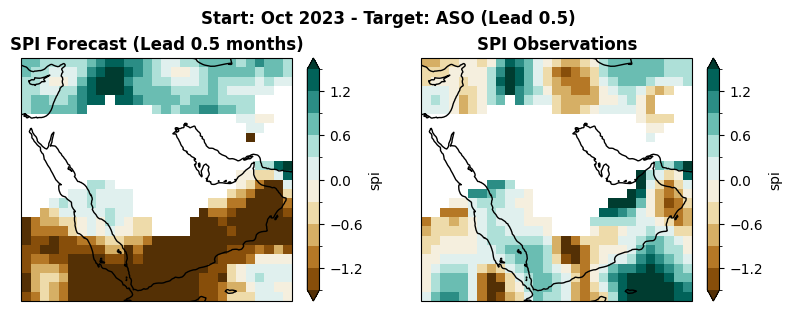

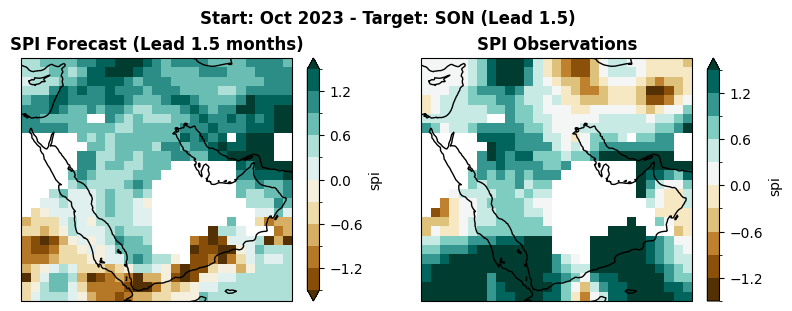

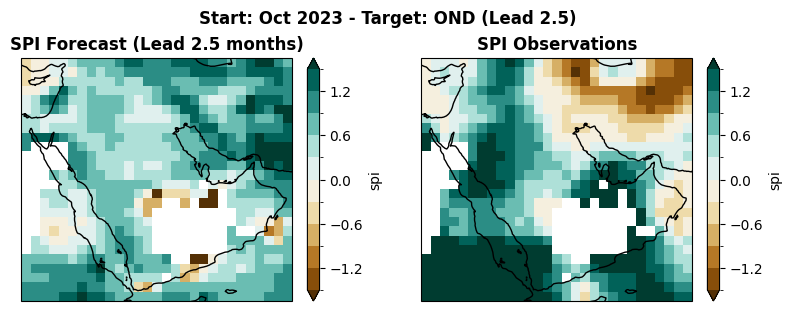

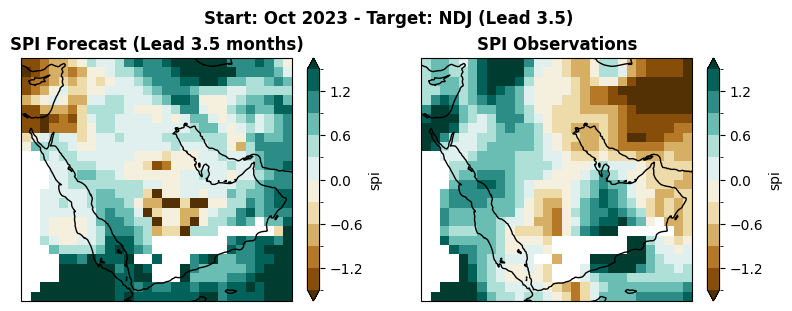

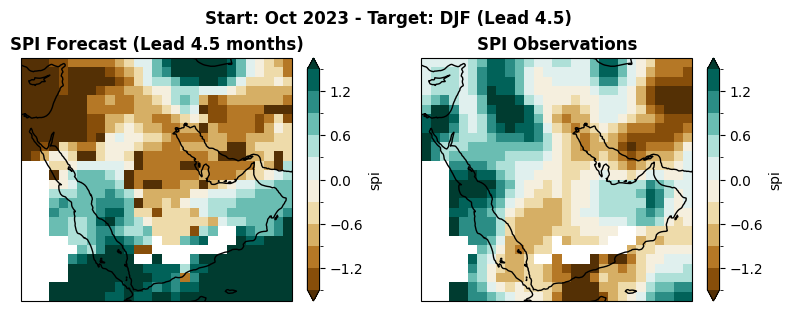

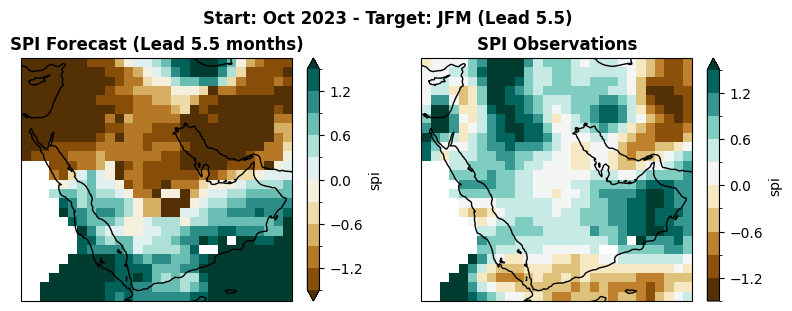

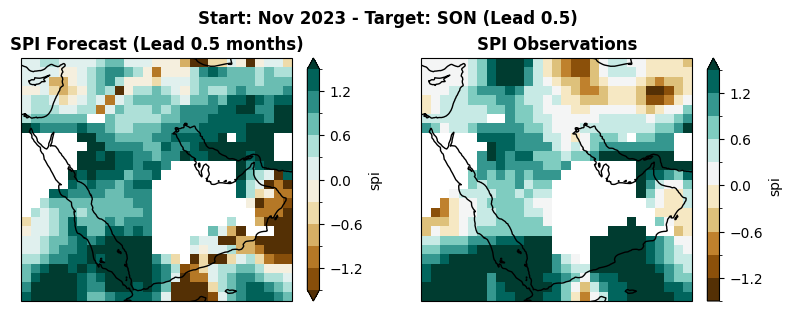

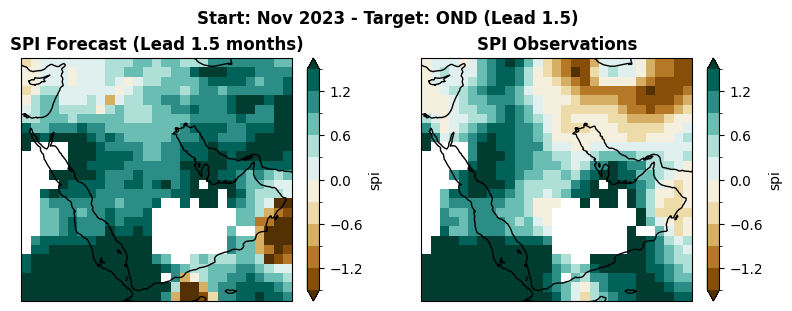

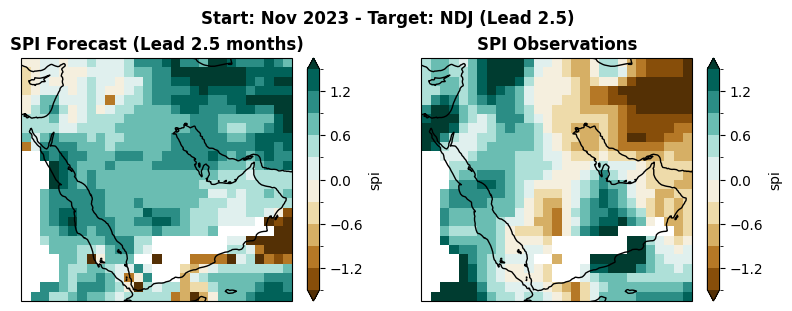

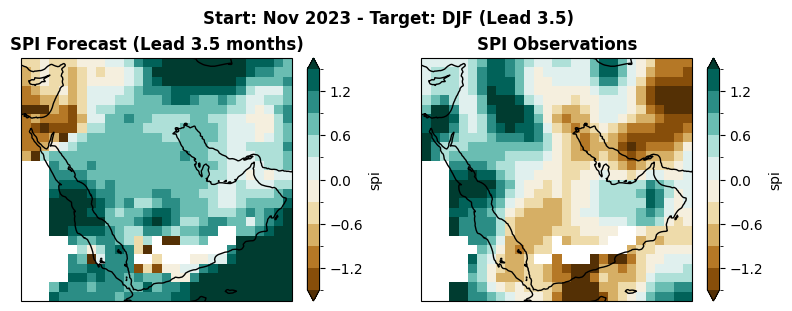

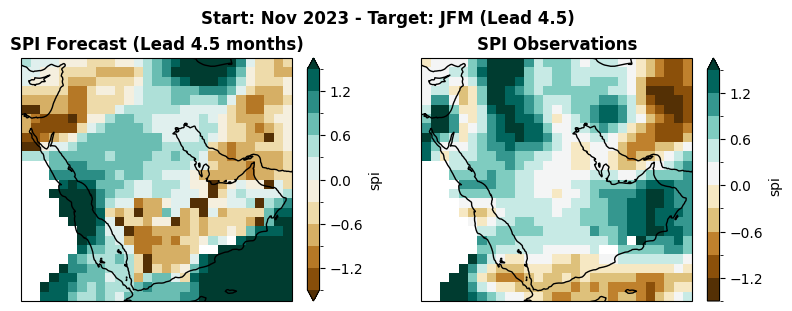

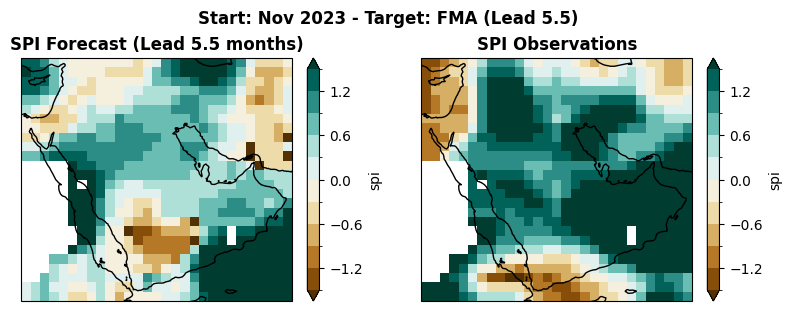

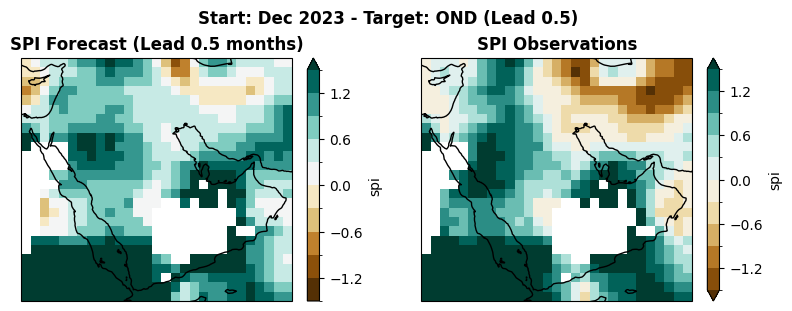

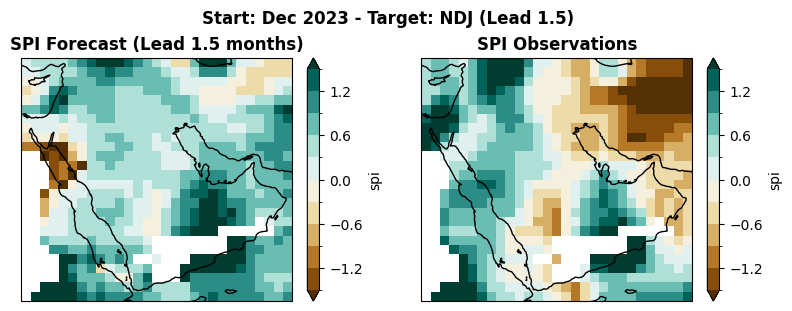

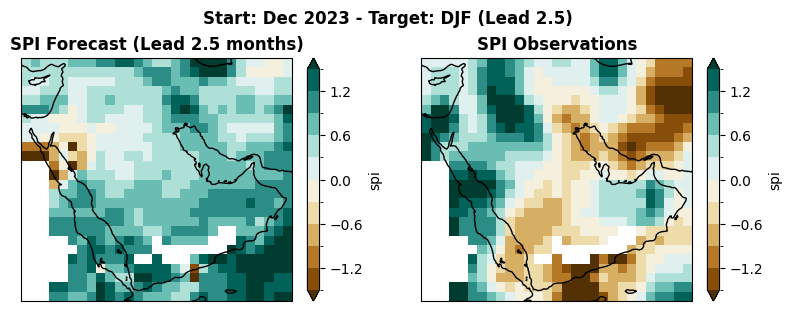

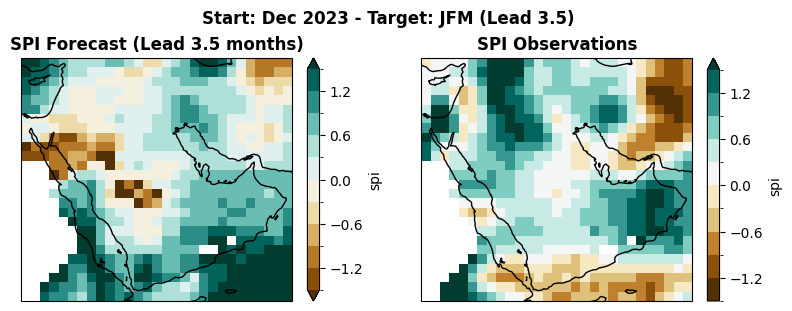

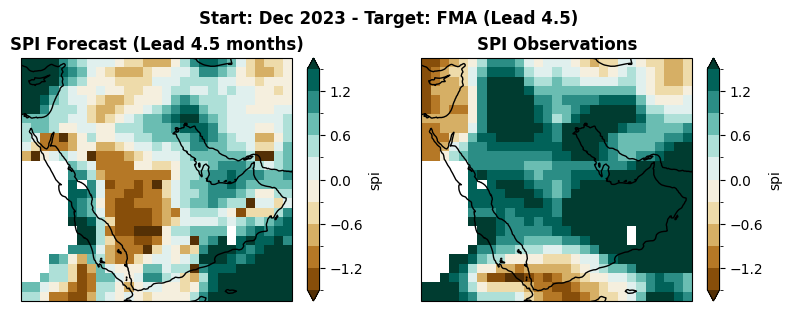

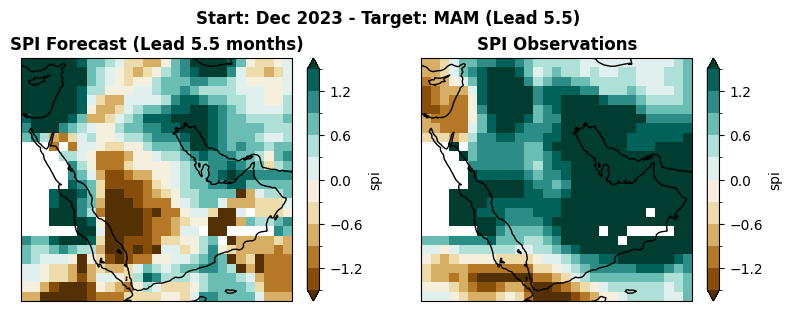

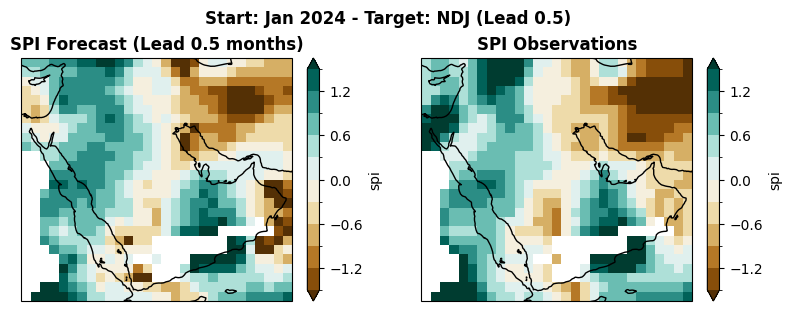

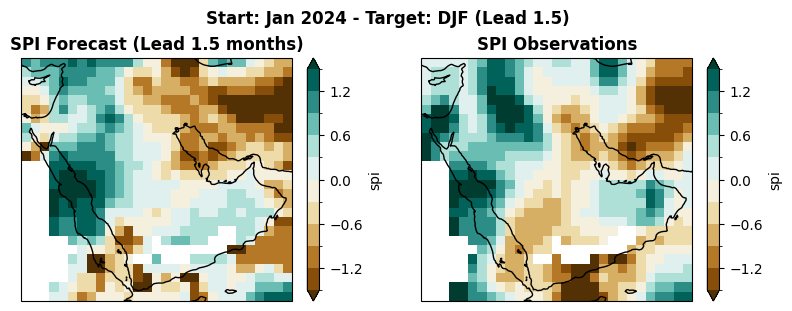

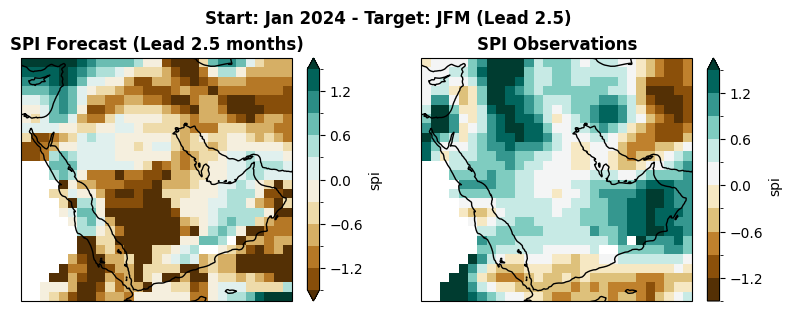

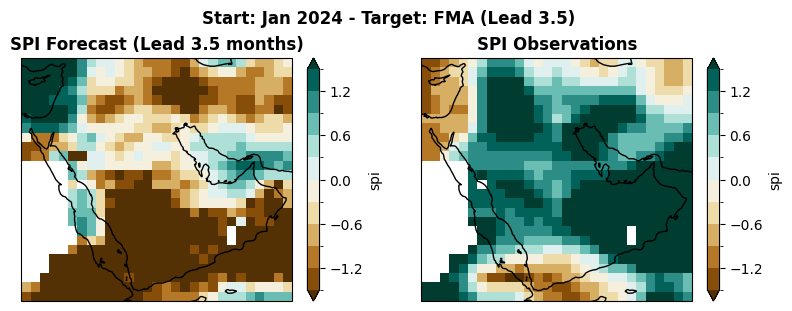

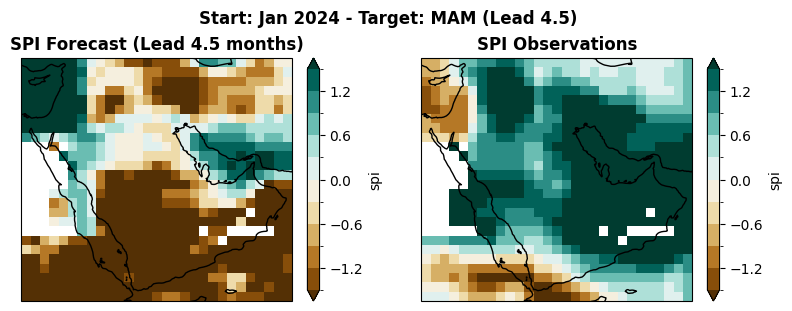

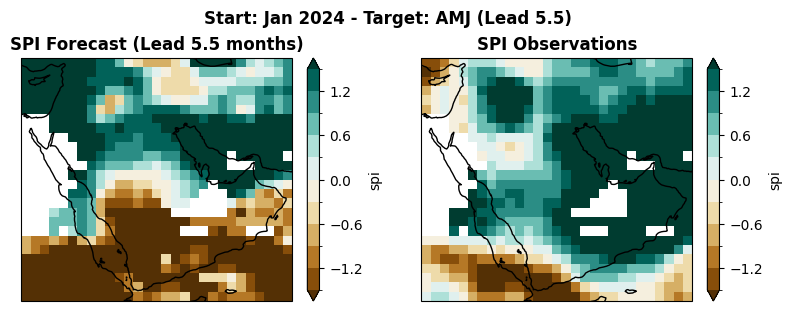

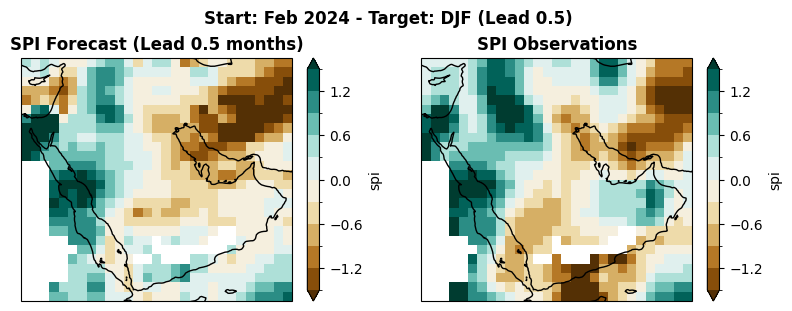

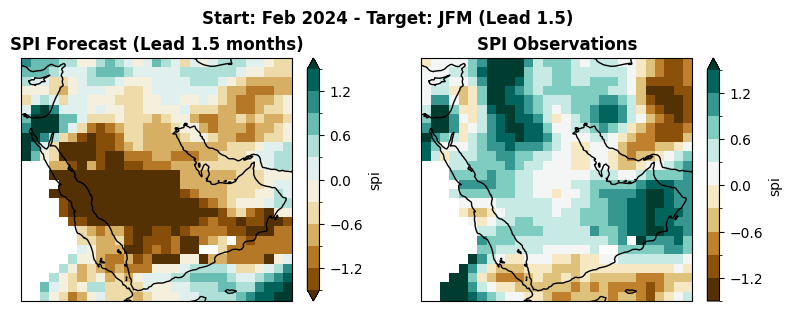

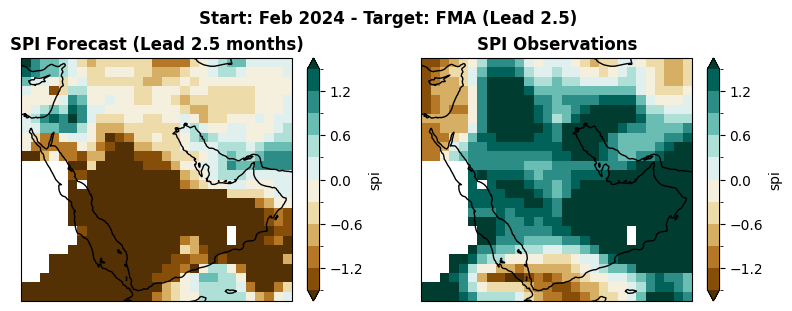

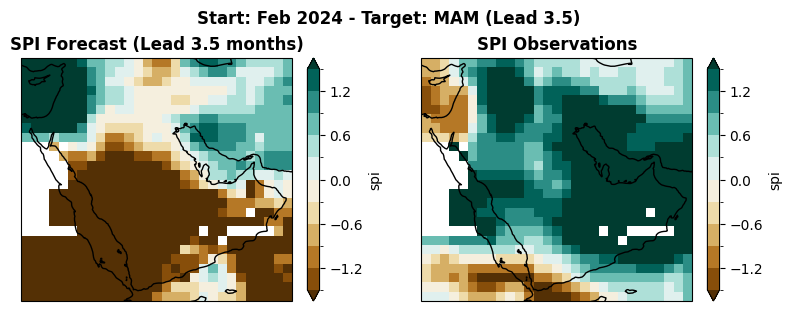

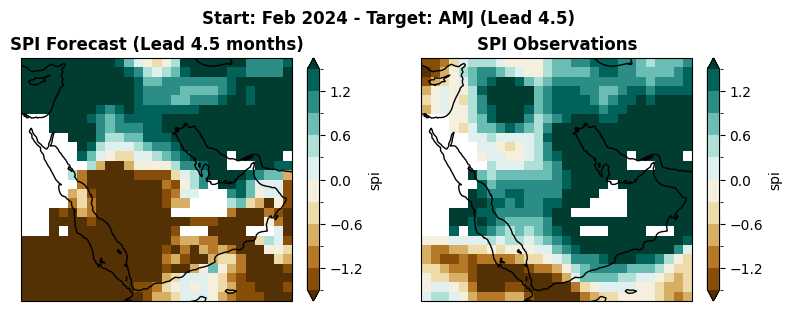

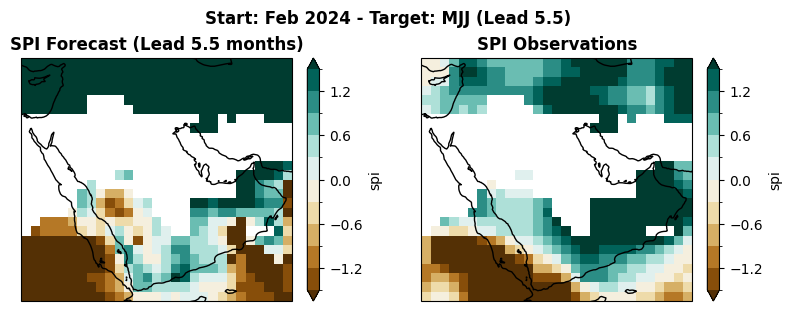

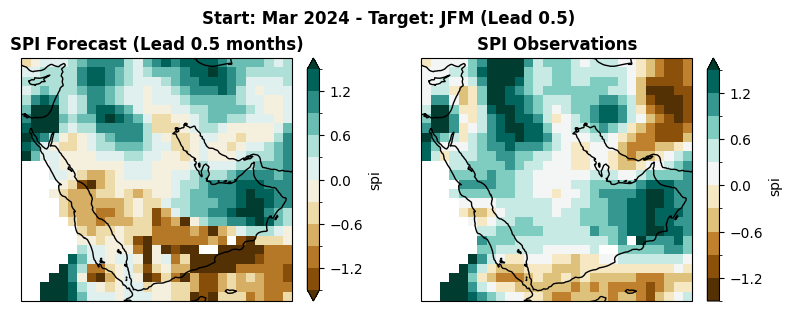

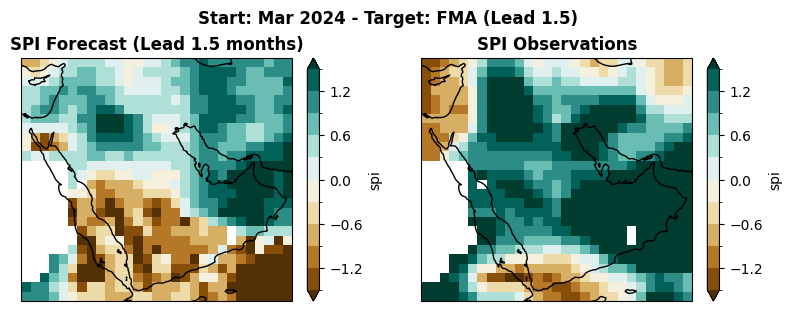

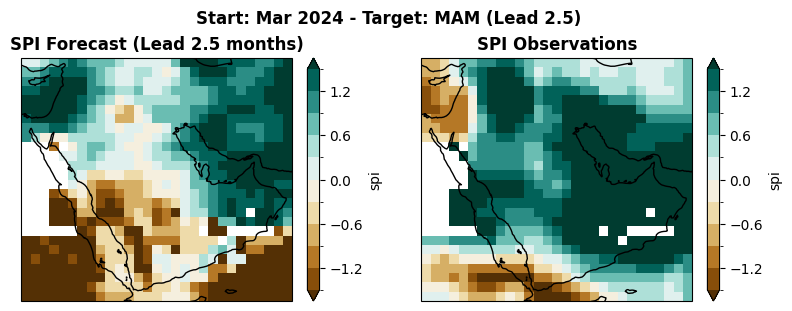

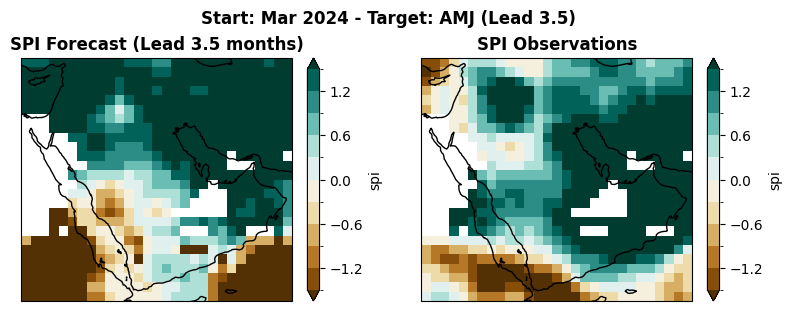

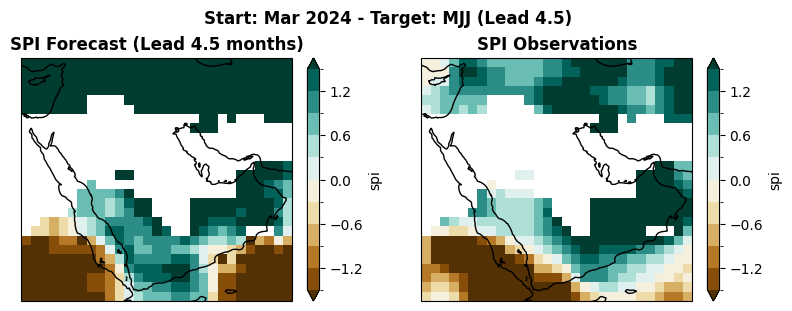

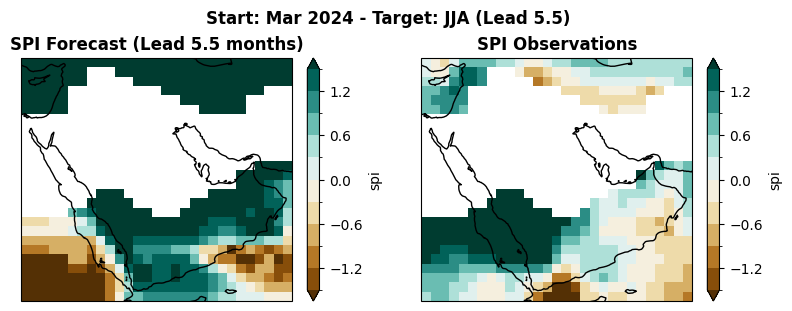

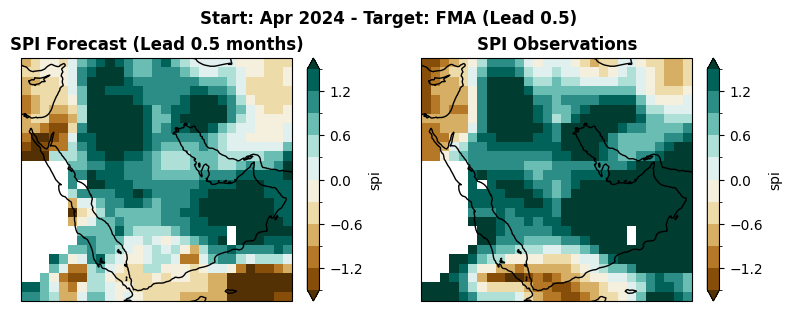

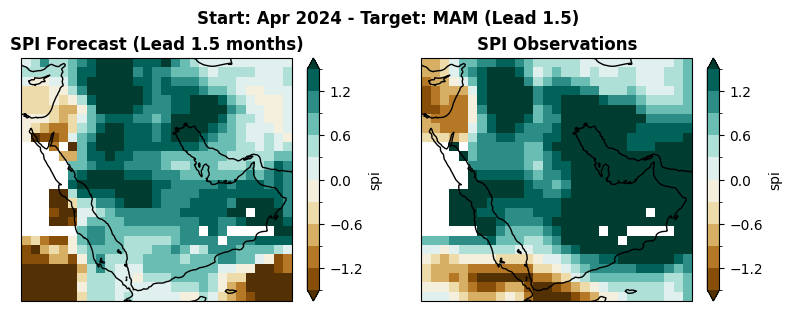

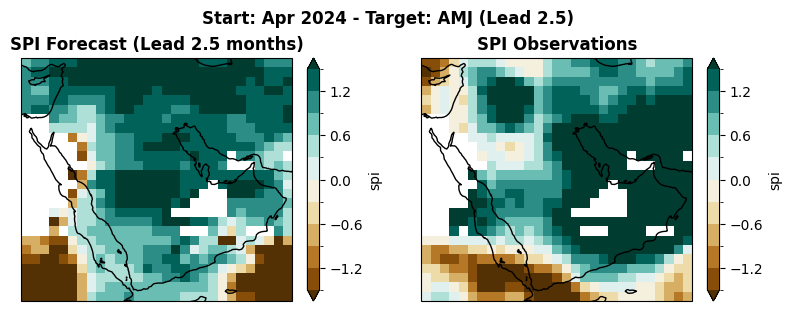

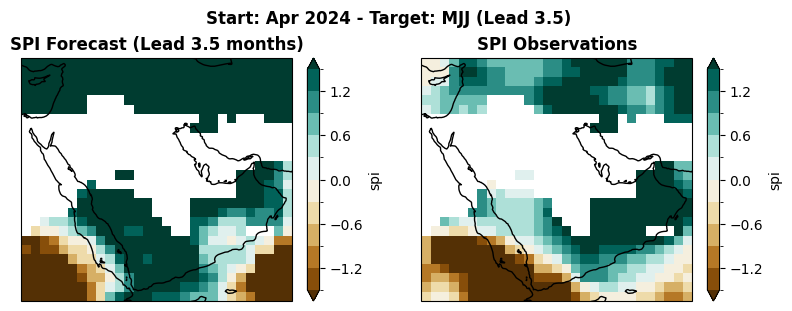

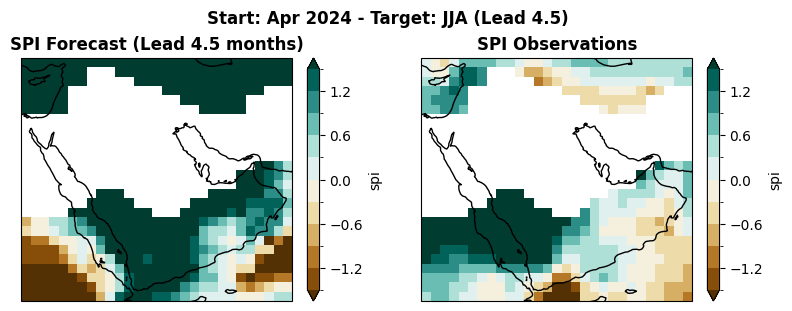

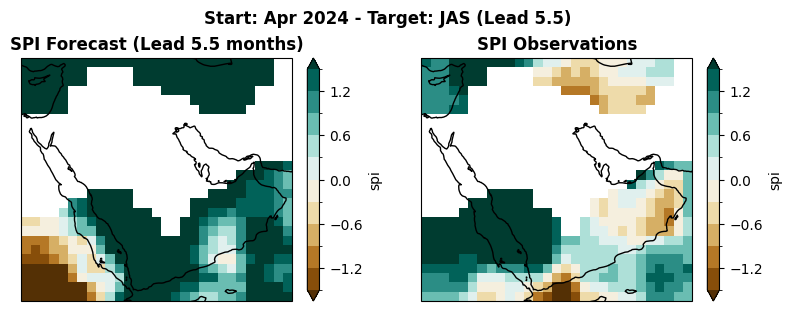

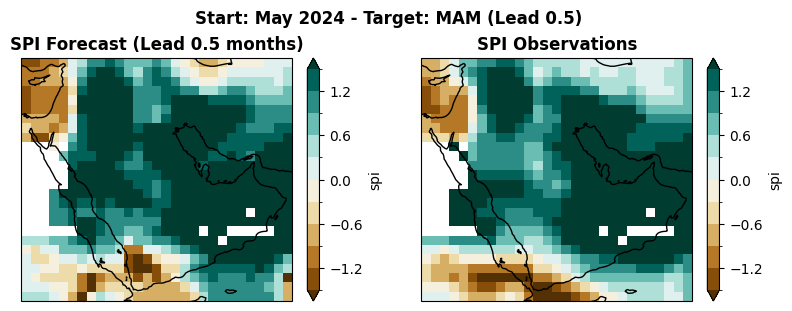

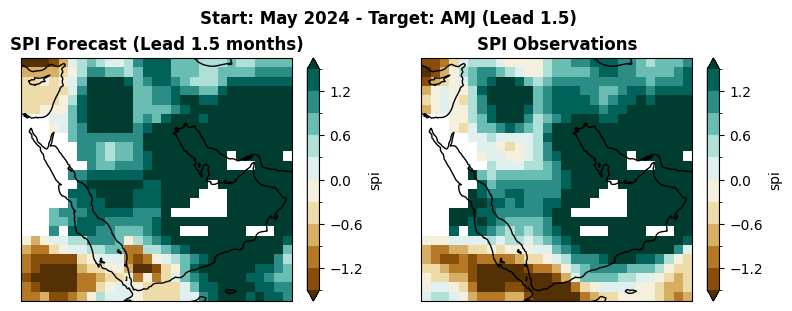

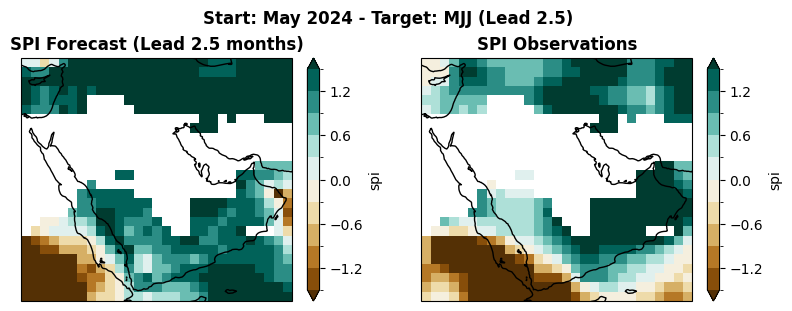

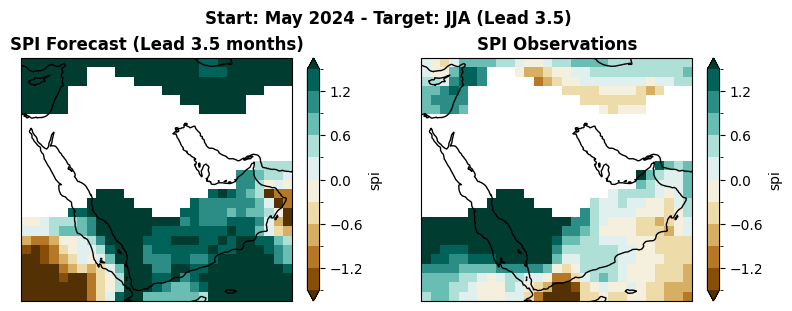

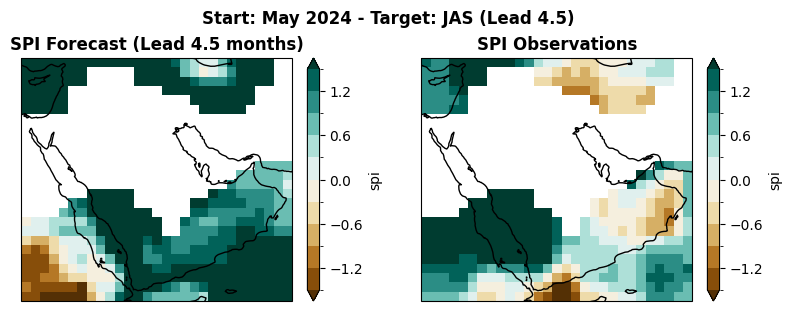

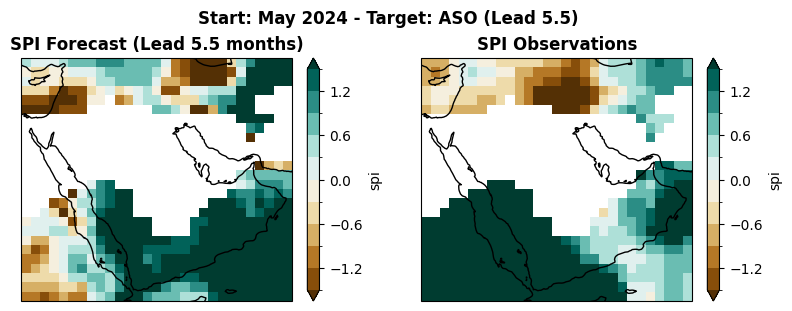

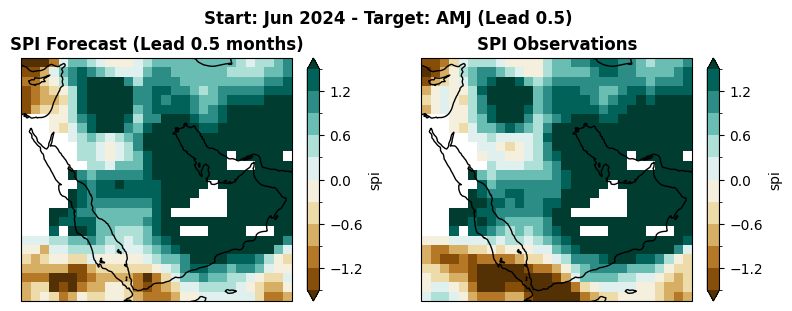

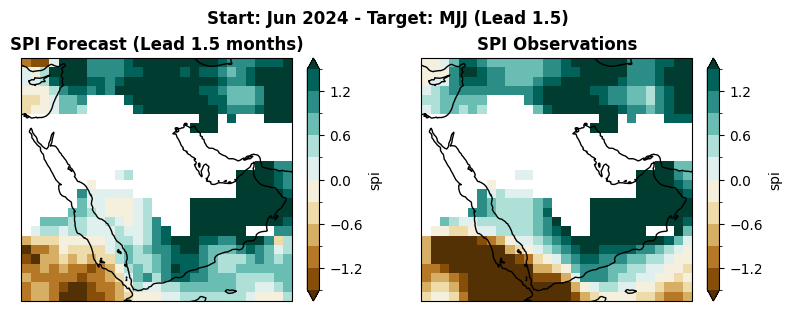

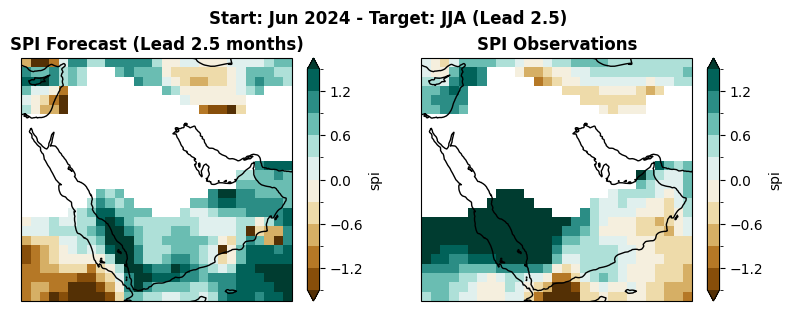

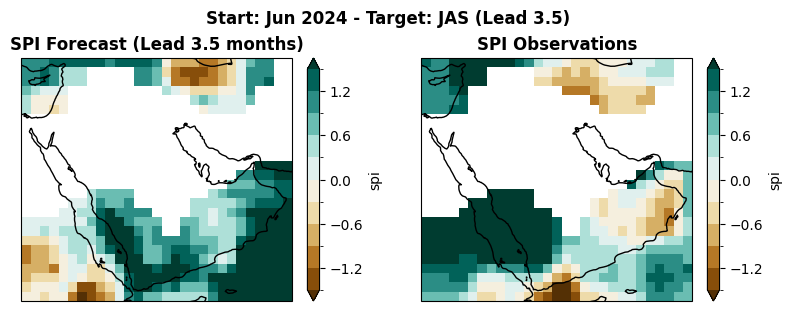

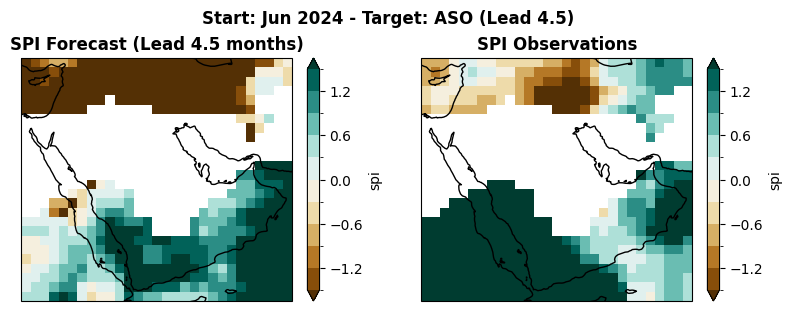

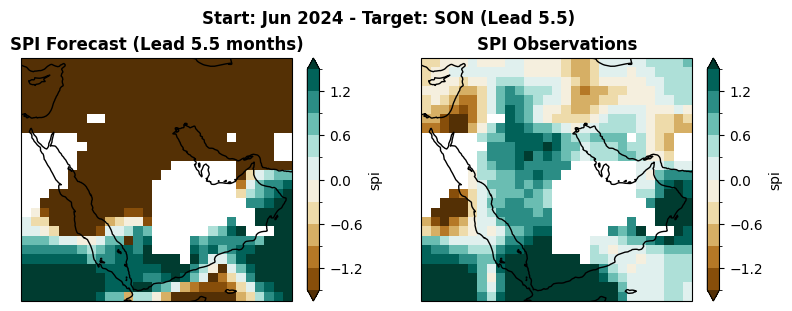

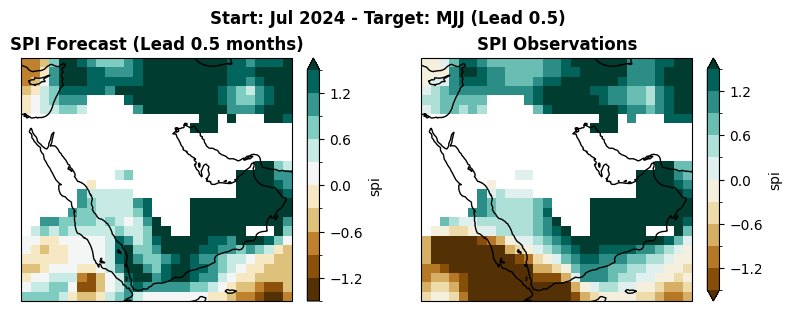

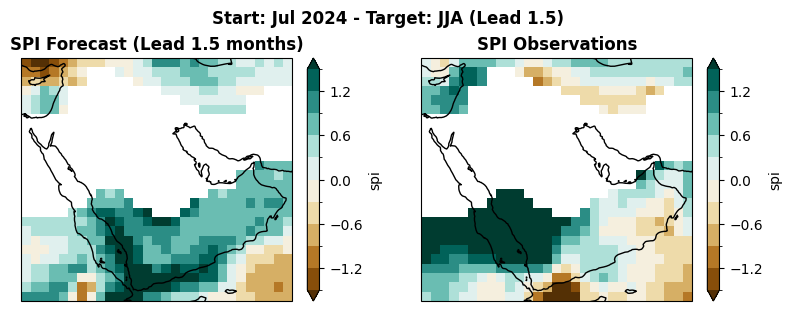

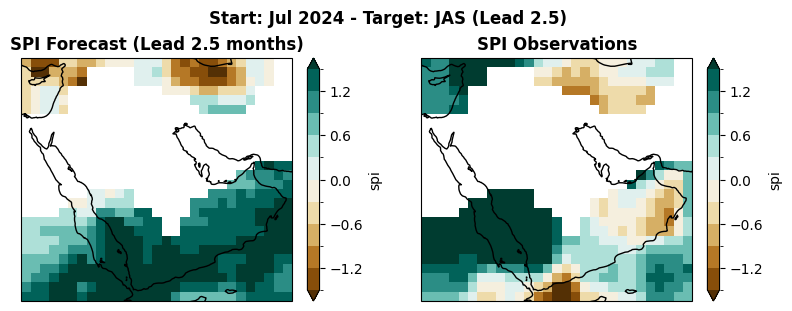

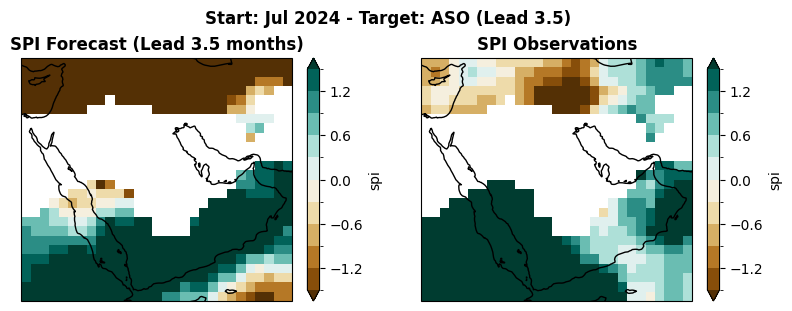

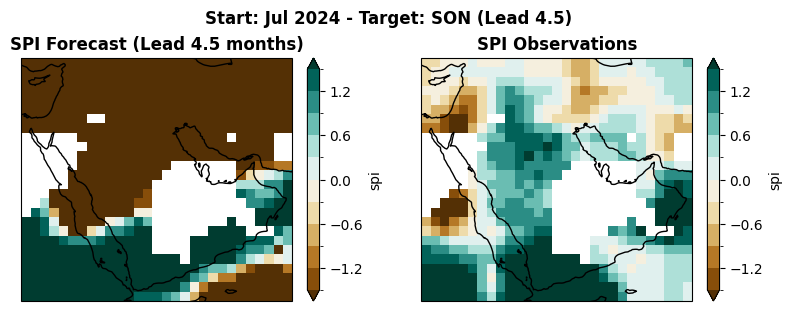

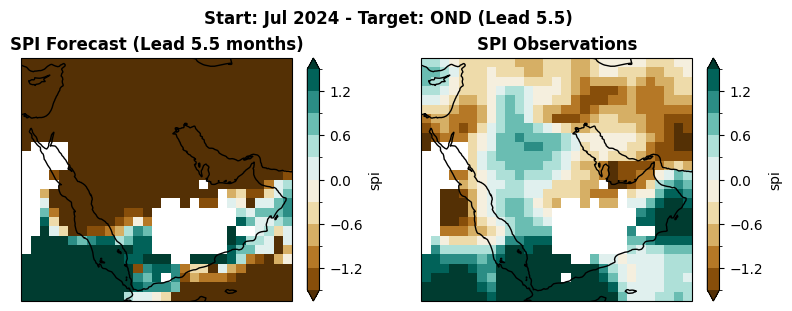

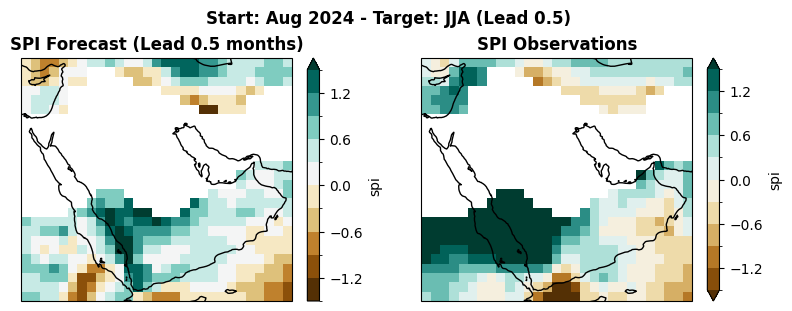

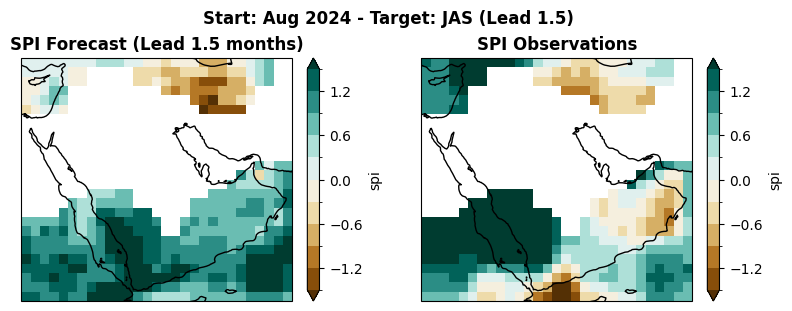

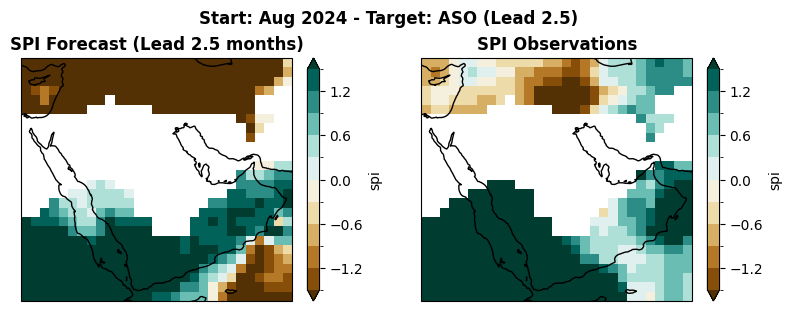

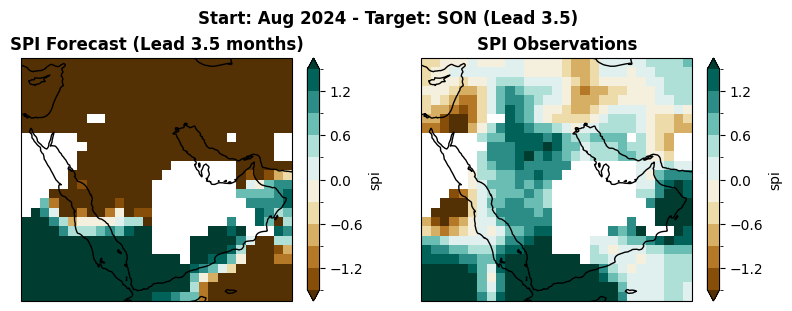

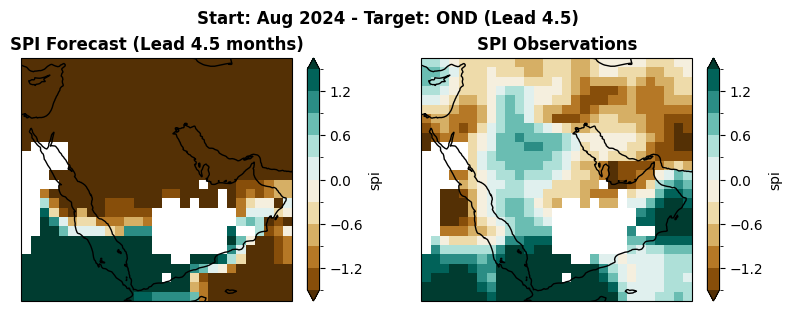

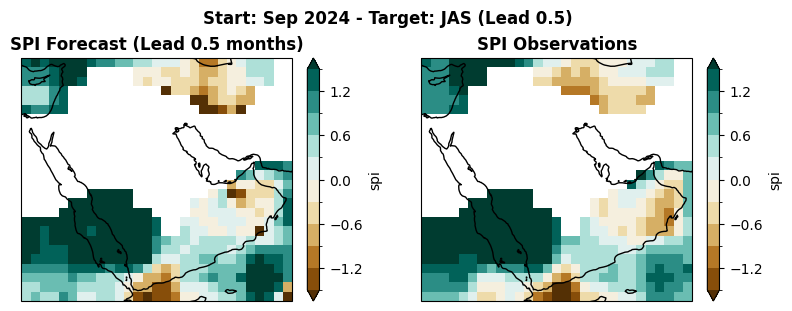

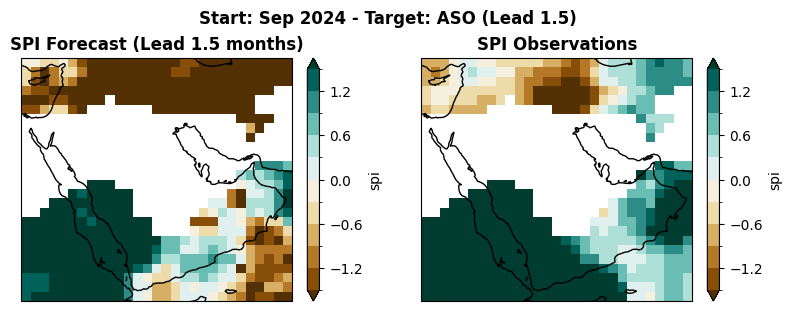

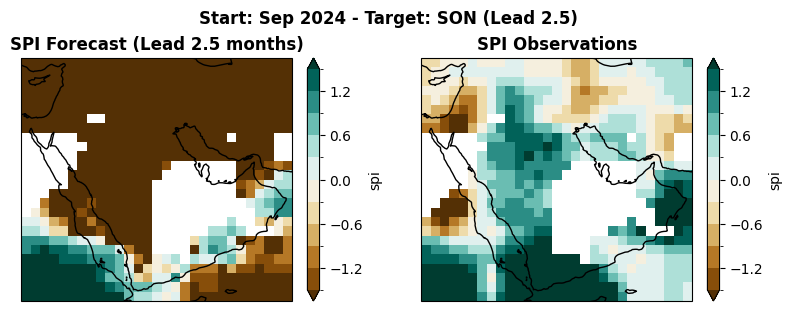

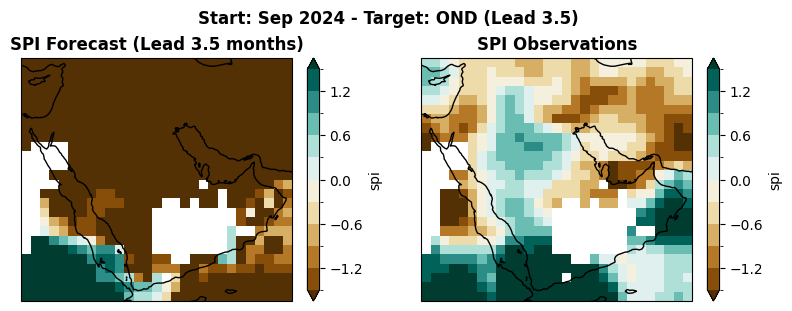

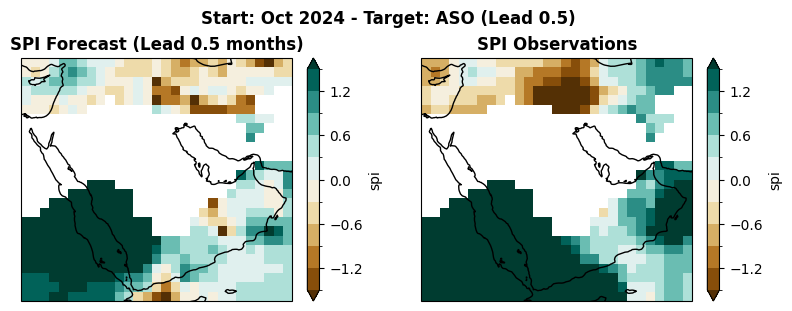

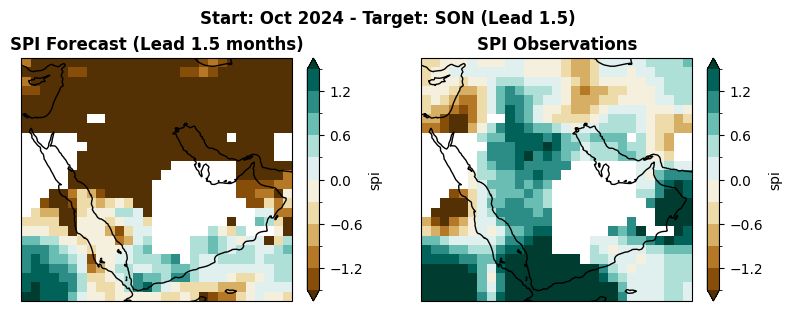

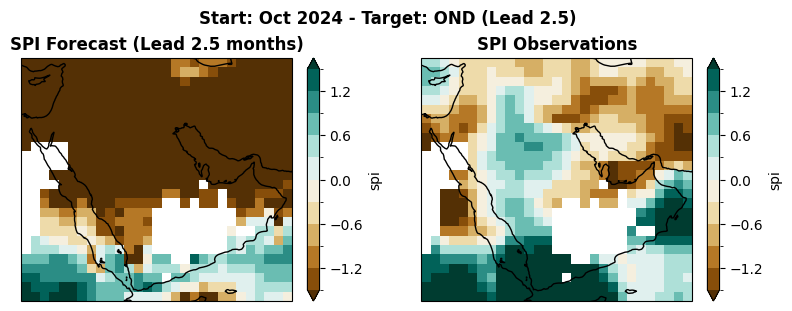

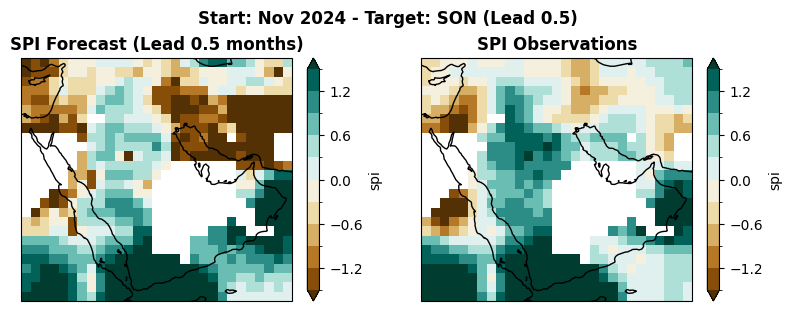

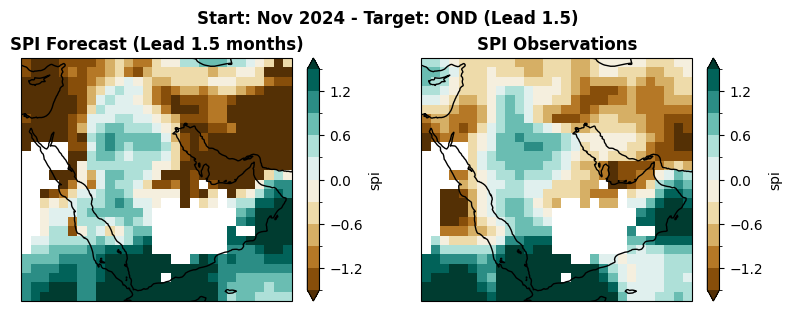

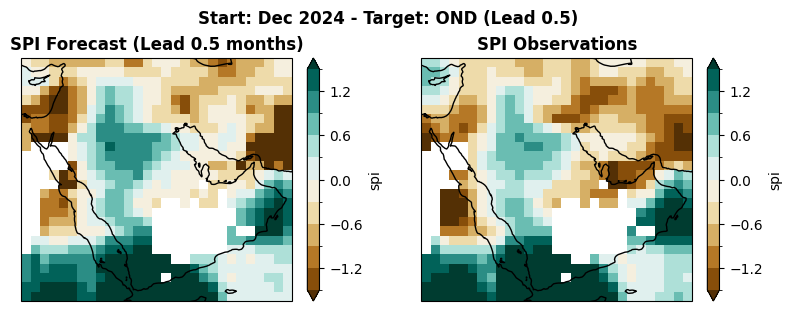

In [24]:
#kepp only forecat with Lead time 0.5 Target date in mon
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasons = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']

for start in spi_fcast_multimodel['S'].values:
    for lead in spi_fcast_multimodel['L'].values:
        spi_fcast_sl = spi_fcast_multimodel.sel(S=start, L=lead)
        precip_fcast_sl = precip_fcast_multimodel.sel(S=start, L=lead)

        target_date = start + pd.DateOffset(months=int(lead - 0.5))
        #if the last obs date is less than the target date, skip
        if target_date > obs_3m['T'].values[-1]:
            continue
        precip_obs_t = obs_3m.sel(T=target_date)
        spi_obs_t = spi_obs.sel(T=target_date)

        # Apply NaN mask of spi_obs_t to spi_fcast_sl
        spi_fcast_sl = spi_fcast_sl.where(~np.isnan(spi_obs_t))

        # Format start date
        start_str = pd.to_datetime(start).strftime('%b %Y')

        # Identify the target season
        target_month = pd.to_datetime(target_date).month
        target_season = seasons[target_month - 1]

        # Plot SPI forecast and observations with a projection
        fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True,
                                 subplot_kw={'projection': ccrs.PlateCarree()})

        spi_fcast_sl.plot(ax=axes[0], vmin=-1.5, vmax=1.5, cmap='BrBG', levels=11, add_colorbar=True)
        spi_obs_t.plot(ax=axes[1], vmin=-1.5, vmax=1.5, cmap='BrBG', levels=11, add_colorbar=True)

        for ax in axes:
            ax.coastlines()  # Add coastlines

        axes[0].set_title(f"SPI Forecast (Lead {lead} months)", fontweight='bold')
        axes[1].set_title(f"SPI Observations", fontweight='bold')

        plt.suptitle(f"Start: {start_str} - Target: {target_season} (Lead {lead})", fontweight='bold')
        plt.show()
        # Save the figure
        fig.savefig(f'figures/forecast2324/spi_{start_str}_{target_season}_L{lead}.png', dpi=300)




